# Table of Contents <a name='top'></a>
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#function)<br>
3. [Model 1 dataset (Mark's dataset)](#ds1) <br>
  3a. [Preprocessing](#ds1preprocess)<br>
  3b. [EDA](#ds1explore)<br>
  3c. [Modeling](#ds1modeling)<br>
4. [Model 2 dataset (original dataset)](#ds2)<br>
  4a. [Preprocessing](#ds2preprocess)<br>
  4b. [EDA](#ds2explore)<br>
  4c. [Modeling](#ds2modeling)


---
## 1. Import Packages <a name='imports'></a>
[jump to top](#top)<br>

In [ ]:
!pip install -q chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.1 MB/s eta 0:00:00


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## uncomment these if not already installed
# !pip install chart_studio
# !pip install textstat

import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords


# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
# import cufflinks
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# imblearn
import imblearn

# File system manangement
import os

# Pytorch
import torch

#Transformers
from transformers import BertTokenizer, TFBertModel

#google collab drive mount
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




Mounted at /content/drive


---
## 2. Define Functions <a name='function'></a>
[jump to top](#top)<br>

**Text pre-processing functions**

In [ ]:
# use of these functions is just temporary, ultimatley we will need to preprocess using BERT functions like in HW2

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    text = re.sub('\n', ' ', text)
    '''
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)'''
    return text

In [ ]:
def target_distributions(df):
  """Visuallize the distribution of each of the 6 targets for a given dataset"""

  # full distrubution for each score

  fig, axs = plt.subplots(nrows = 2,
                          ncols = 3,
                          figsize = (12, 6))

  categories = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

  a = [list(df[cat].value_counts().index) for cat in categories]
  a.sort()
  heights = [df[categories[i]].value_counts()[a[i]].values for i in range(6)]

  axs[0, 0].bar(a[0], height = heights[0], edgecolor = "black", width = 0.5)
  axs[0, 0].set_title(categories[0])
  axs[0, 1].bar(a[1], height = heights[1], edgecolor = "black", width = 0.5)
  axs[0, 1].set_title(categories[1])
  axs[0, 2].bar(a[2], height = heights[2], edgecolor = "black", width = 0.5)
  axs[0, 2].set_title(categories[2])
  axs[1, 0].bar(a[3], height = heights[3], edgecolor = "black", width = 0.5)
  axs[1, 0].set_title(categories[3])
  axs[1, 1].bar(a[4], height = heights[4], edgecolor = "black", width = 0.5)
  axs[1, 1].set_title(categories[4])
  axs[1, 2].bar(a[5], height = heights[5], edgecolor = "black", width = 0.5)
  axs[1, 2].set_title(categories[5]);


In [ ]:
def lump(df, bounds = [2, 4]):
  """Group together the ends of the distribution of the targets"""

  categories = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
  lists = [[] for i in range(6)]

  new = df.copy()

  for i,cat in enumerate(categories):
    for score in new[cat]:
        if score >= bounds[0] and score <= bounds[1]:
          lists[i].append(score)
        elif score < bounds[0]:
          lists[i].append(bounds[0])
        elif score > bounds[1]:
          lists[i].append(bounds[1])
    new[cat] = lists[i]

  return new

In [ ]:
def cm_vis(y_true, y_pred):
  """Make six confusion matrices, one for each category"""

  cm = [tf.math.confusion_matrix(y_true[i], y_pred[i].numpy()) for i in range(6)]
  cm = [con/con.numpy().sum(axis=1)[:, tf.newaxis] for con in cm]

  fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))

  # cohesion
  sns.heatmap(cm[0],
              annot=True,
              ax=axs[0, 0])
  axs[0, 0].set_xlabel("Predicted")
  axs[0, 0].set_ylabel("True")
  axs[0, 0].set_title("cohesion")

  # syntax
  sns.heatmap(cm[1],
              annot=True,
              ax=axs[0, 1])
  axs[0, 1].set_xlabel("Predicted")
  axs[0, 1].set_ylabel("True")
  axs[0, 1].set_title("syntax")

  # vocabulary
  sns.heatmap(cm[2],
              annot=True,
              ax=axs[0, 2])
  axs[0, 2].set_xlabel("Predicted")
  axs[0, 2].set_ylabel("True")
  axs[0, 2].set_title("vocabulary")

  # phraseology
  sns.heatmap(cm[3],
              annot=True,
              ax=axs[1, 0])
  axs[1, 0].set_xlabel("Predicted")
  axs[1, 0].set_ylabel("True")
  axs[1, 0].set_title("phraseology")

  # grammar
  sns.heatmap(cm[4],
              annot=True,
              ax=axs[1, 1])
  axs[1, 1].set_xlabel("Predicted")
  axs[1, 1].set_ylabel("True")
  axs[1, 1].set_title("grammar")

  # conventions
  sns.heatmap(cm[5],
              annot=True,
              ax=axs[1, 2])
  axs[1, 2].set_xlabel("Predicted")
  axs[1, 2].set_ylabel("True")
  axs[1, 2].set_title("conventions");

---
## 3. Model 1 dataset (Mark's dataset) <a name='ds1'></a>
[jump to top](#top)<br>

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# File path to the dataset
file_path = '/content/drive/MyDrive/Colab/train.csv'

# Read the dataset into a Pandas DataFrame

pretrain = pd.read_csv(file_path)
print(pretrain.shape)
pretrain.head()

(3911, 8)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


---
### 3a. Preprocessing <a name='ds1preprocess'></a>
[jump to top](#top)<br>

In [ ]:
#check for nulls

pretrain.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

In [ ]:
# let's remove the '\n' appearances in the essay text. We'll create a new column with the cleaner text

pretrain["text_clean"] = pretrain["full_text"].apply(str).apply(lambda x: text_preprocessing(x))
pretrain.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_clean
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,I think that students would benefit from learn...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,When a problem is a change you have to let it ...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"Dear, Principal If u change the school policy..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,The best time in life is when you become yours...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,Small act of kindness can impact in other peop...


In [ ]:
# take a look at one essay, notice that there are no longer any '\n' in the text

pretrain['text_clean'][10]

"Do you think its a good idea for students to commit to a career at a young age? In some societies, students are expected to identity a career by the time they enter high school. Yes it is a good idea to start young because your already step ahead, you will have background knowledge about the career classes you choose and once you get older you won't have time to choose an career. Also taking courses in high school will help you choose your career like for an example academy classes.  As a students taking a career course, will help them learn more about that career and you will have background knowledge about that career. for an example I'm taking auto technology in highschol becuase I want to learn more about cars and how to fix them. after high school I will be going to a community college so I can learn an advance auto technology class and move on and thats I'm going to succeed in life.  Another reason why its a good idea for students to commit to a career at young age is becuase it

In [ ]:
# Convert the column to a list of strings
text_clean = pretrain['text_clean'].tolist()

# Create a TensorFlow constant tensor from the list of strings
full_text_tensor = tf.constant(text_clean, dtype=tf.string)
print(full_text_tensor[0])
print(full_text_tensor[1])
print(type(full_text_tensor))

pretrain['text_tensor'] = full_text_tensor

tf.Tensor(b"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.  The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.  most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up a

In [ ]:
# split the data into training, validation, and testing sets

# train --> 60%
# val   --> 20%
# test  --> 20%

train, test = model_selection.train_test_split(pretrain, test_size = 0.2, shuffle = True)
train, val = model_selection.train_test_split(train, test_size = 0.25, shuffle = True)

train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_clean,text_tensor
1103,550D53DE2832,I understand what are you tying to say about d...,2.5,3.0,3.0,2.5,2.5,2.5,I understand what are you tying to say about d...,"b""I understand what are you tying to say about..."
188,0E3C1F059C31,Technology is the best way to contact your fam...,3.0,3.0,3.5,3.5,3.5,3.0,Technology is the best way to contact your fam...,"b""Technology is the best way to contact your f..."
3796,FAC8305E209D,"When I was working at the Daycare, it was not ...",2.5,3.0,3.0,2.5,2.0,3.0,"When I was working at the Daycare, it was not ...","b""When I was working at the Daycare, it was no..."
2408,B3145EA3395B,"To see someone impression, that might be possi...",2.5,3.0,2.5,2.5,2.0,2.0,"To see someone impression, that might be possi...","b'To see someone impression, that might be pos..."
1885,8E2EB0B4B92C,"The author Ralph waldo Emerson once wrote "" To...",2.0,3.0,3.0,3.0,3.0,2.5,"The author Ralph waldo Emerson once wrote "" To...","b'The author Ralph waldo Emerson once wrote "" ..."


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
all_train = train['text_tensor'].tolist()
all_val = val['text_tensor'].tolist()
all_test = test['text_tensor'].tolist()

all_train = [x.decode('utf-8') for x in all_train]
all_val = [x.decode('utf-8') for x in all_val]
all_test = [x.decode('utf-8') for x in all_test]

MAX_SEQUENCE_LENGTH = 600

x_train = bert_tokenizer(all_train,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

x_val = bert_tokenizer(all_val,
                       max_length=MAX_SEQUENCE_LENGTH,
                       truncation=True,
                       padding='max_length',
                       return_tensors='tf')

x_test = bert_tokenizer(all_test,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

In [ ]:
columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


#y_train = pt_train[columns].values.reshape((-1,))
#y_test = pt_test[columns].values.reshape((-1,))


y_train = [train[col].values.reshape((-1,)) for col in columns]
y_val = [val[col].values.reshape((-1,)) for col in columns]
y_test = [test[col].values.reshape((-1,)) for col in columns]

# transform the target values because having decimels confuses tensorflow
y_train = [(2*col - 2).astype(int) for col in y_train]
y_val = [(2*col - 2).astype(int) for col in y_val]
y_test = [(2*col - 2).astype(int) for col in y_test]
# map:
# 1 --> 0
# 1.5 --> 1
# ...
# 4.5 --> 7
# 5 --> 8
# i.e. scores now range from 0 to 8 by 1 rather than 1 to 5 by 0.5



# training shapes
print('x_train shape:               ', x_train['input_ids'].shape)
print('y_train shape (one category):', y_train[0].shape)
print("-"*50)

# validation shapes
print('x_val shape:                 ', x_val['input_ids'].shape)
print('y_val shape (one category):  ', y_val[0].shape)
print("-"*50)

# testing shapes
print('x_test shape:                ', x_test['input_ids'].shape)
print('y_test shape (one category): ', y_test[0].shape)



x_train shape:                (2346, 600)
y_train shape (one category): (2346,)
--------------------------------------------------
x_val shape:                  (782, 600)
y_val shape (one category):   (782,)
--------------------------------------------------
x_test shape:                 (783, 600)
y_test shape (one category):  (783,)


---
### 3b. EDA <a name='ds1explore'></a>
[jump to top](#top)<br>

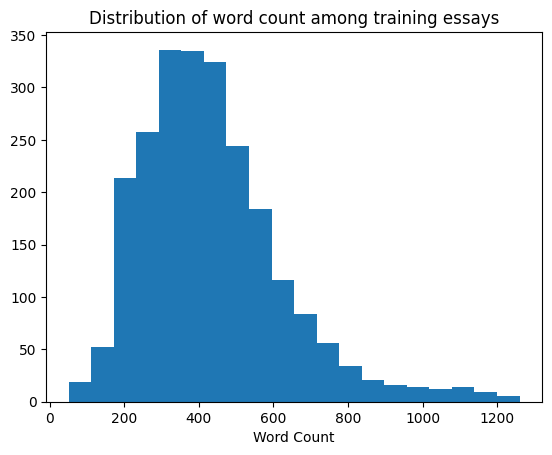

In [ ]:
# visualize the distribution of word count among our essays

lengths = []
for essay in train["full_text"]:
  tokenized = essay.split()
  lengths.append(len(tokenized))

# plot a histogram and add a vertical line add 75% of the data
plt.hist(lengths, bins = 20)
# plt.axvline(x = 518.75, color = "black")
plt.xlabel("Word Count")
plt.title("Distribution of word count among training essays");

In [ ]:
# Take a look at some summary stats of the scores for each potential output, as well as for the word count

train["word_count"] = lengths
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count
count,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000
mean,3.129582,3.036871,3.239130,3.114663,3.033248,3.089088,433.596334
std,0.659232,0.644002,0.581098,0.658924,0.694144,0.666557,190.162665
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,299.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,407.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,528.750000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1260.000000


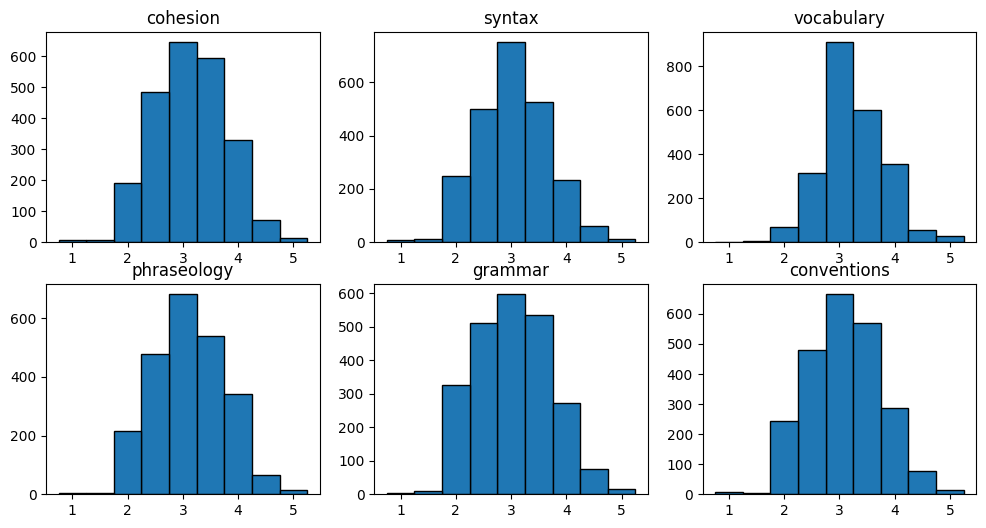

In [ ]:
# full distrubution for each score (training examples only)

target_distributions(train)

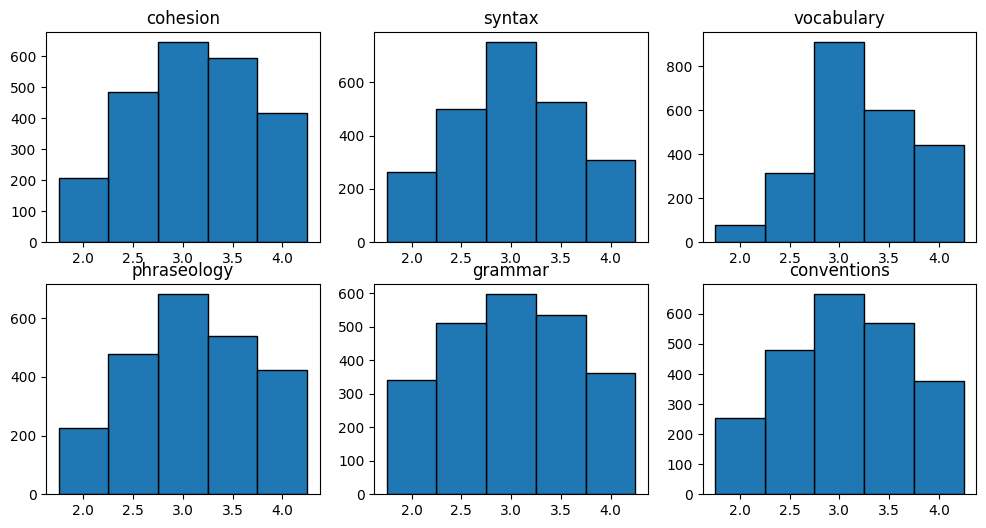

In [ ]:
# make a copy of the training set
df = train.copy()

# alter the target values to lump together values at the edges of the range
df = lump(df)

# visualize the new distribution
target_distributions(df)

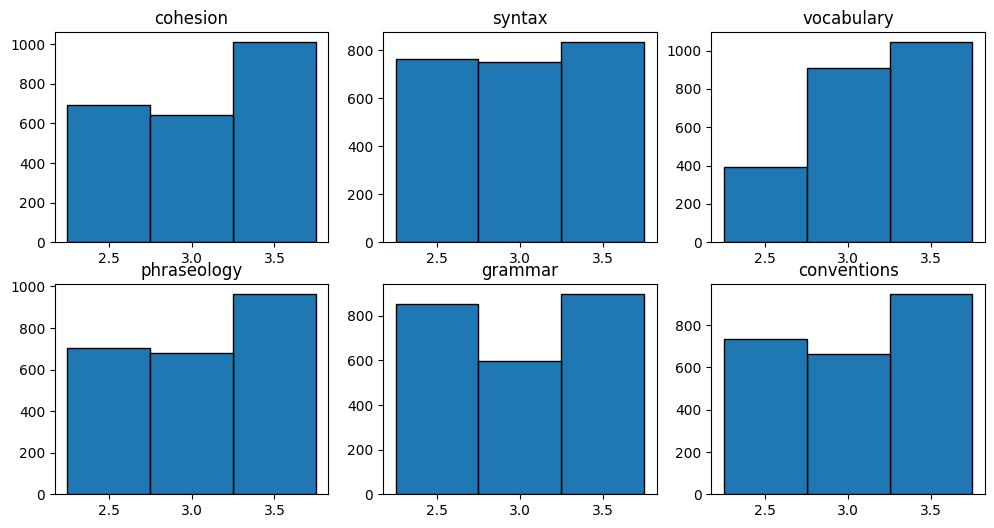

In [ ]:
# make a copy of the training set
df2 = train.copy()

# alter the target values to lump together values at the edges of the range
df2 = lump(df2, [2.5, 3.5])

# visualize the new distribution
target_distributions(df2)

In [ ]:
# # downsample based on the 'syntax' category

# sampling_strategy = {0: 295, 1: 488, 2: 500, 3: 528, 4: 304} # need to change bc we didn't set a seed for thec train_test_split

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 11)
# X_resampled, syntax_resampled = rus.fit_resample(X = df.drop(columns = "syntax"), y = (2*df["syntax"] - 4).astype(int))

# syntax_resampled = (syntax_resampled + 4)/2

# df_downsampled = pd.concat([X_resampled, pd.DataFrame(syntax_resampled)], axis = 1)

In [ ]:
# # distribution for data lumped at 2 and 4, then downsampled

# target_distributions(df_downsampled)

Looks like this successfully lopped off the 3's within `syntax`, but it didn't really help for the other categories. So to bring the 3's down for each category would mean throwing away a lot of data

**Let's proceed to use build one model using only 3 categories (ie lumped at 2.5 and 3.5), one model using 5 categories (lumped at at 2 and 4), and one model with all the categories but using class weights.**

In [ ]:
# cut off y at 2 and 4 (9 classes --> 5 classes)

# lump the edges of the target distributions together
train_wide = lump(train)
val_wide = lump(val)
test_wide = lump(test)

# reshape
y_train_wide = [train_wide[col].values.reshape((-1,)) for col in columns]
y_val_wide = [val_wide[col].values.reshape((-1,)) for col in columns]
y_test_wide = [test_wide[col].values.reshape((-1,)) for col in columns]

# transform the new target to start at 0 and increase in increments of 1
y_train_wide = [(2*col - 4).astype(int) for col in y_train_wide]
y_val_wide = [(2*col - 4).astype(int) for col in y_val_wide]
y_test_wide = [(2*col - 4).astype(int) for col in y_test_wide]

In [ ]:
# cut off y at 2.5 and 3.5 (9 classes --> 3 classes)

# lump the edges of the target distributions together
train_narrow = lump(train, bounds = [2.5, 3.5])
val_narrow = lump(val, bounds = [2.5, 3.5])
test_narrow = lump(test, bounds = [2.5, 3.5])

# reshape
y_train_narrow = [train_narrow[col].values.reshape((-1,)) for col in columns]
y_val_narrow = [val_narrow[col].values.reshape((-1,)) for col in columns]
y_test_narrow = [test_narrow[col].values.reshape((-1,)) for col in columns]

# transform the new target to start at 0 and increase in increments of 1
y_train_narrow = [(2*col - 5).astype(int) for col in y_train_narrow]
y_val_narrow = [(2*col - 5).astype(int) for col in y_val_narrow]
y_test_narrow = [(2*col - 5).astype(int) for col in y_test_narrow]

---
### 3c. Modeling <a name='ds1modeling'></a>
[jump to top](#top)<br>

In [ ]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     hidden_size = 200,
                                     dropout = 0.3,
                                     learning_rate = 0.00005,
                                     MAX_SEQUENCE_LENGTH = 600,
                                     num_classes = 9):
    """
    Pretraining fine tuning to produce 6 output scores
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    cohesion_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='cohesion_output')(hidden)
    syntax_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='syntax_output')(hidden)
    vocabulary_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='vocabulary_output')(hidden)
    phraseology_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='phraseology_output')(hidden)
    grammar_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='grammar_output')(hidden)
    conventions_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='conventions_output')(hidden)

    inputs = [input_ids, token_type_ids, attention_mask]
    outputs = [cohesion_score, syntax_score, vocabulary_score, phraseology_score, grammar_score, conventions_score]

    classification_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='sparse_categorical_crossentropy',  # Updated loss function
                                 metrics=['accuracy'])

    return classification_model


In [ ]:
model_narrow = create_bert_classification_model(bert_model, num_classes=3)

In [ ]:
model_narrow_history = model_narrow.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train_narrow,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val_narrow),
    batch_size=32,
    epochs=5
)

Epoch 1/5
74/74 [==============================] - 198s 2s/step - loss: 6.9524 - cohesion_output_loss: 1.1338 - syntax_output_loss: 1.1458 - vocabulary_output_loss: 1.1088 - phraseology_output_loss: 1.1791 - grammar_output_loss: 1.1904 - conventions_output_loss: 1.1945 - cohesion_output_accuracy: 0.3811 - syntax_output_accuracy: 0.3892 - vocabulary_output_accuracy: 0.3922 - phraseology_output_accuracy: 0.3815 - grammar_output_accuracy: 0.3717 - conventions_output_accuracy: 0.3887 - val_loss: 6.1959 - val_cohesion_output_loss: 1.0361 - val_syntax_output_loss: 1.0188 - val_vocabulary_output_loss: 1.0022 - val_phraseology_output_loss: 1.0227 - val_grammar_output_loss: 1.0649 - val_conventions_output_loss: 1.0512 - val_cohesion_output_accuracy: 0.4808 - val_syntax_output_accuracy: 0.4795 - val_vocabulary_output_accuracy: 0.4578 - val_phraseology_output_accuracy: 0.4668 - val_grammar_output_accuracy: 0.4437 - val_conventions_output_accuracy: 0.4488
Epoch 2/5
74/74 [=========================

In [ ]:
pd.DataFrame(model_narrow_history.history)

,loss,cohesion_output_loss,syntax_output_loss,vocabulary_output_loss,phraseology_output_loss,grammar_output_loss,conventions_output_loss,cohesion_output_accuracy,syntax_output_accuracy,vocabulary_output_accuracy,phraseology_output_accuracy,grammar_output_accuracy,conventions_output_accuracy,val_loss,val_cohesion_output_loss,val_syntax_output_loss,val_vocabulary_output_loss,val_phraseology_output_loss,val_grammar_output_loss,val_conventions_output_loss,val_cohesion_output_accuracy,val_syntax_output_accuracy,val_vocabulary_output_accuracy,val_phraseology_output_accuracy,val_grammar_output_accuracy,val_conventions_output_accuracy
0,6.952414,1.133791,1.145844,1.108827,1.179078,1.190379,1.194495,0.381074,0.389173,0.392157,0.381500,0.371697,0.388747,6.195915,1.036099,1.018822,1.002204,1.022664,1.064900,1.051227,0.480818,0.479540,0.457801,0.466752,0.443734,0.448849
1,6.382336,1.076335,1.054645,1.026691,1.071749,1.088565,1.064351,0.450980,0.444160,0.457801,0.439471,0.421142,0.458227,5.979192,1.012871,0.990327,0.960635,0.989485,1.017309,1.008564,0.496164,0.506394,0.512788,0.489770,0.512788,0.515345
2,6.141264,1.042789,1.017550,0.980218,1.038296,1.044163,1.018249,0.469309,0.467604,0.502984,0.473146,0.473572,0.504689,5.803281,0.990247,0.962326,0.924668,0.965010,0.987838,0.973192,0.526854,0.523018,0.543478,0.525575,0.543478,0.538363
3,6.005123,1.018771,0.986181,0.952788,1.035016,1.017629,0.994738,0.489770,0.516624,0.516624,0.472293,0.512788,0.513214,5.720715,0.980801,0.961065,0.907878,0.944856,0.966030,0.960085,0.531969,0.508951,0.548593,0.533248,0.557545,0.529412
4,5.869455,1.001191,0.970450,0.947480,1.000773,0.983292,0.966272,0.512788,0.513214,0.522165,0.504263,0.548167,0.530264,5.647585,0.970990,0.949151,0.893669,0.937139,0.949169,0.947467,0.528133,0.520460,0.570332,0.542199,0.565217,0.546036


In [ ]:
# capture predictions

# probabilities
predicted_probabilities_train = model_narrow.predict([x_train["input_ids"], x_train["token_type_ids"], x_train["attention_mask"]])
predicted_probabilities_val = model_narrow.predict([x_val["input_ids"], x_val["token_type_ids"], x_val["attention_mask"]])
predicted_probabilities_test = model_narrow.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

# predictions
predictions_train = tf.argmax(predicted_probabilities_train, axis=-1)
predictions_val = tf.argmax(predicted_probabilities_val, axis=-1)
predictions_test = tf.argmax(predicted_probabilities_test, axis=-1)

25/25 [==============================] - 40s 2s/step


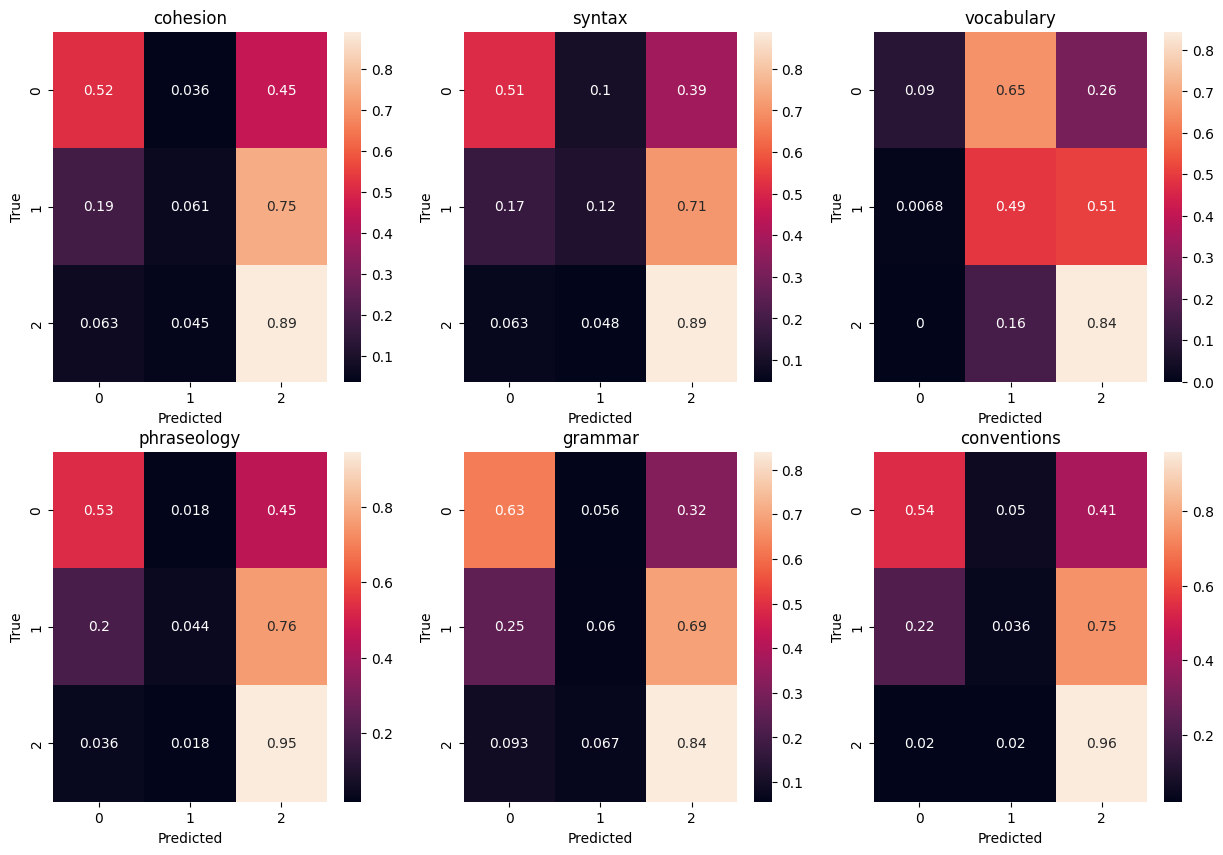

In [ ]:
cm_vis(y_test_narrow, predictions_test)

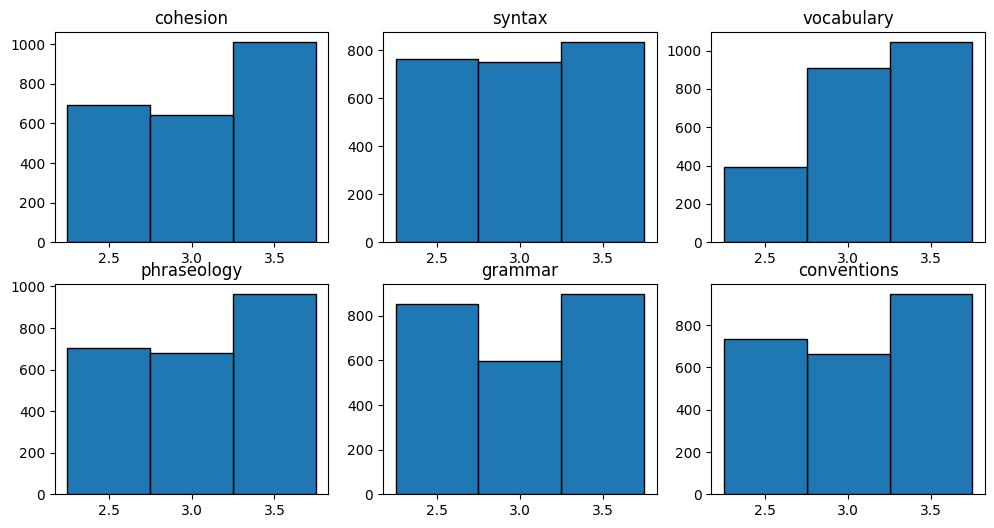

In [ ]:
# as a reminder, this is what the distribution of the training data looked like

target_distributions(df2)

**It looks like even a small amount of class imbalance can heavily skew the performance of the classifier in favor of the majority class(es)**

In [ ]:
class_weights = [{} for i in range(6)]
total = len(train)

for i in range(6):
  for j in range(3):
    count = len(y_train_narrow[i][y_train_narrow[i]==j])
    prop = count/total
    weight = 0.5*(1/prop) # the inverse of the proportion of the class, divided by 2
    class_weights[i][j] = weight

In [ ]:
class_weights

[{0: 1.6975397973950797, 1: 1.8186046511627907, 2: 1.1613861386138613},
 {0: 1.5373525557011793, 1: 1.564, 2: 1.4081632653061225},
 {0: 2.9771573604060912, 1: 1.2904290429042904, 2: 1.12464046021093},
 {0: 1.6685633001422477, 1: 1.722466960352423, 2: 1.2193347193347193},
 {0: 1.3767605633802817, 1: 1.964824120603015, 2: 1.3076923076923077},
 {0: 1.5959183673469388, 1: 1.76390977443609, 2: 1.239957716701903}]

In [ ]:
class_weights = {0:[], 1:[], 2:[]}

for i in range(6):
  for j in range(3):
    count = len(y_train_narrow[i][y_train_narrow[i]==j])
    prop = count/total
    weight = 0.5*(1/prop) # the inverse of the proportion of the class, divided by 2
    class_weights[j].append(weight)

In [ ]:
class_weights

{0: [1.6975397973950797,
  1.5373525557011793,
  2.9771573604060912,
  1.6685633001422477,
  1.3767605633802817,
  1.5959183673469388],
 1: [1.8186046511627907,
  1.564,
  1.2904290429042904,
  1.722466960352423,
  1.964824120603015,
  1.76390977443609],
 2: [1.1613861386138613,
  1.4081632653061225,
  1.12464046021093,
  1.2193347193347193,
  1.3076923076923077,
  1.239957716701903]}

In [ ]:
model_narrow_class_weights = create_bert_classification_model(bert_model, num_classes=3)

In [ ]:
model_narrow_class_weights_history = model_narrow_class_weights.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train_narrow,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val_narrow),
    batch_size=32,
    epochs=2,
    class_weight=class_weights
)

ValueError: ignored

**uh-oh**

In [ ]:
model_wide = create_bert_classification_model(bert_model, num_classes=5)

In [ ]:
model_wide_history = model_wide.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train_wide,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val_wide),
    batch_size=32,
    epochs=5
)

In [ ]:
pd.DataFrame(model_wide_history.history)

In [ ]:
model_class_weights = create_bert_classification_model(bert_model)

In [ ]:
model_class_weights_history = model_class_weights.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train_wide,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val_wide),
    batch_size=32,
    epochs=5
)

In [ ]:
pd.DataFrame(model_class_weights_history.history)

In [ ]:
#create hyperparameter table
hyperp_df = pd.DataFrame(columns=['learning_rate', 'loss_function', 'epochs', 'kappa_mse_train', 'kappa_mse_val', 'kappa_mse_test'])
hyperp_df

,learning_rate,loss_function,epochs,kappa_mse_train,kappa_mse_val,kappa_mse_test


In [ ]:

def add_hyperp(learning_rate, loss_function, num_epochs, kappa_mse_train, kappa_mse_val, kappa_mse_test):
  '''input the hyperparameters and results you want to test, this function will add it to the hyperp_df'''
  hyperp_df.loc[len(hyperp_df)] = [learning_rate, loss_function, num_epochs, kappa_mse_train, kappa_mse_val, kappa_mse_test]



In [ ]:
#initialize the hyperparameters

learn_rate = .00005
loss_function = "Multiclass"
num_epochs = 2



In [ ]:
big_model = create_bert_classification_model(bert_model, learning_rate = learn_rate)

In [ ]:
big_model_history = big_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),
    batch_size=32,
    epochs=num_epochs
)

Epoch 1/2
74/74 [==============================] - 197s 2s/step - loss: 12.7012 - cohesion_output_loss: 2.0628 - syntax_output_loss: 2.0631 - vocabulary_output_loss: 2.1793 - phraseology_output_loss: 2.0852 - grammar_output_loss: 2.0986 - conventions_output_loss: 2.2123 - cohesion_output_accuracy: 0.1850 - syntax_output_accuracy: 0.2276 - vocabulary_output_accuracy: 0.2485 - phraseology_output_accuracy: 0.2212 - grammar_output_accuracy: 0.2003 - conventions_output_accuracy: 0.2012 - val_loss: 10.9500 - val_cohesion_output_loss: 1.7987 - val_syntax_output_loss: 1.7850 - val_vocabulary_output_loss: 1.7477 - val_phraseology_output_loss: 1.8318 - val_grammar_output_loss: 1.8820 - val_conventions_output_loss: 1.9048 - val_cohesion_output_accuracy: 0.2737 - val_syntax_output_accuracy: 0.3478 - val_vocabulary_output_accuracy: 0.4207 - val_phraseology_output_accuracy: 0.3184 - val_grammar_output_accuracy: 0.2430 - val_conventions_output_accuracy: 0.3043
Epoch 2/2
74/74 [=======================

In [ ]:
# capture predictions

# probabilities
predicted_probabilities_train = big_model.predict([x_train["input_ids"], x_train["token_type_ids"], x_train["attention_mask"]])
predicted_probabilities_val = big_model.predict([x_val["input_ids"], x_val["token_type_ids"], x_val["attention_mask"]])
predicted_probabilities_test = big_model.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

# predictions
predictions_train = tf.argmax(predicted_probabilities_train, axis=-1)
predictions_val = tf.argmax(predicted_probabilities_val, axis=-1)
predictions_test = tf.argmax(predicted_probabilities_test, axis=-1)

25/25 [==============================] - 39s 2s/step


In [ ]:
# evaluate train, val, and test predictions

train_kappas = []
val_kappas = []
test_kappas = []


for i in range(5):
  kappa_train = cohen_kappa_score(y_train[i], predictions_train[i])
  kappa_val = cohen_kappa_score(y_val[i], predictions_val[i])
  kappa_test = cohen_kappa_score(y_test[i], predictions_test[i])

  train_kappas.append(kappa_train)
  val_kappas.append(kappa_val)
  test_kappas.append(kappa_test)


train_kappa_mean = np.mean(train_kappas)
val_kappa_mean = np.mean(val_kappas)
test_kappa_mean = np.mean(test_kappas)

In [ ]:
# # Training accuracy CHANGE TO KAPPA or MSE
# train_kappa_mse = np.mean([
#     big_model_history.history['cohesion_output_accuracy'][-1],
#     big_model_history.history['syntax_output_accuracy'][-1],
#     big_model_history.history['vocabulary_output_accuracy'][-1],
#     big_model_history.history['phraseology_output_accuracy'][-1],
#     big_model_history.history['grammar_output_accuracy'][-1],
#     big_model_history.history['conventions_output_accuracy'][-1]
# ])

# # CHANGE TO KAPPA OR MSE FOR VALIDATION
# val_kappa_mse = np.mean([
#     big_model_history.history['val_cohesion_output_accuracy'][-1],
#     big_model_history.history['val_syntax_output_accuracy'][-1],
#     big_model_history.history['val_vocabulary_output_accuracy'][-1],
#     big_model_history.history['val_phraseology_output_accuracy'][-1],
#     big_model_history.history['val_grammar_output_accuracy'][-1],
#     big_model_history.history['val_conventions_output_accuracy'][-1]
# ])

# ^ I'm just going to calculate the kappa score directly using the predictions rather than trying to get tensorflow to output it
# I tried to add kappa to the list of metrics in the model compilation but it was throwing an error


add_hyperp(learn_rate, loss_function, num_epochs, train_kappa_mean, val_kappa_mean, test_kappa_mean)
hyperp_df

,learning_rate,loss_function,epochs,kappa_mse_train,kappa_mse_val,kappa_mse_test
0,0.00005,Multiclass,2,0.036365,0.041619,0.041614


<Figure size 2000x700 with 0 Axes>

<Axes: >

Text(0.5, 47.7222222222222, 'Predicted')

Text(220.72222222222223, 0.5, 'True')

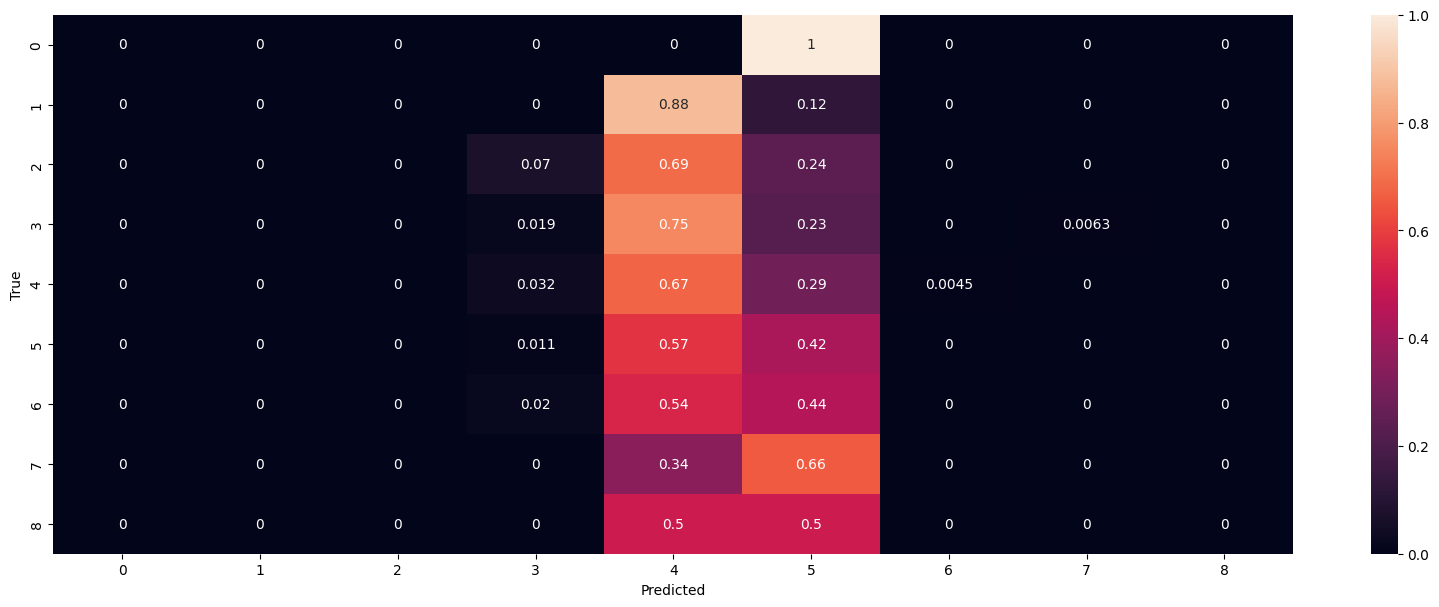

In [ ]:
# Cohesion (confusion matrix)

cm = tf.math.confusion_matrix(y_test[0], predictions_test[0].numpy())
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(cm,
            annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

**Straightforward model**

In [ ]:
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=0)

In [ ]:
bert_classification_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

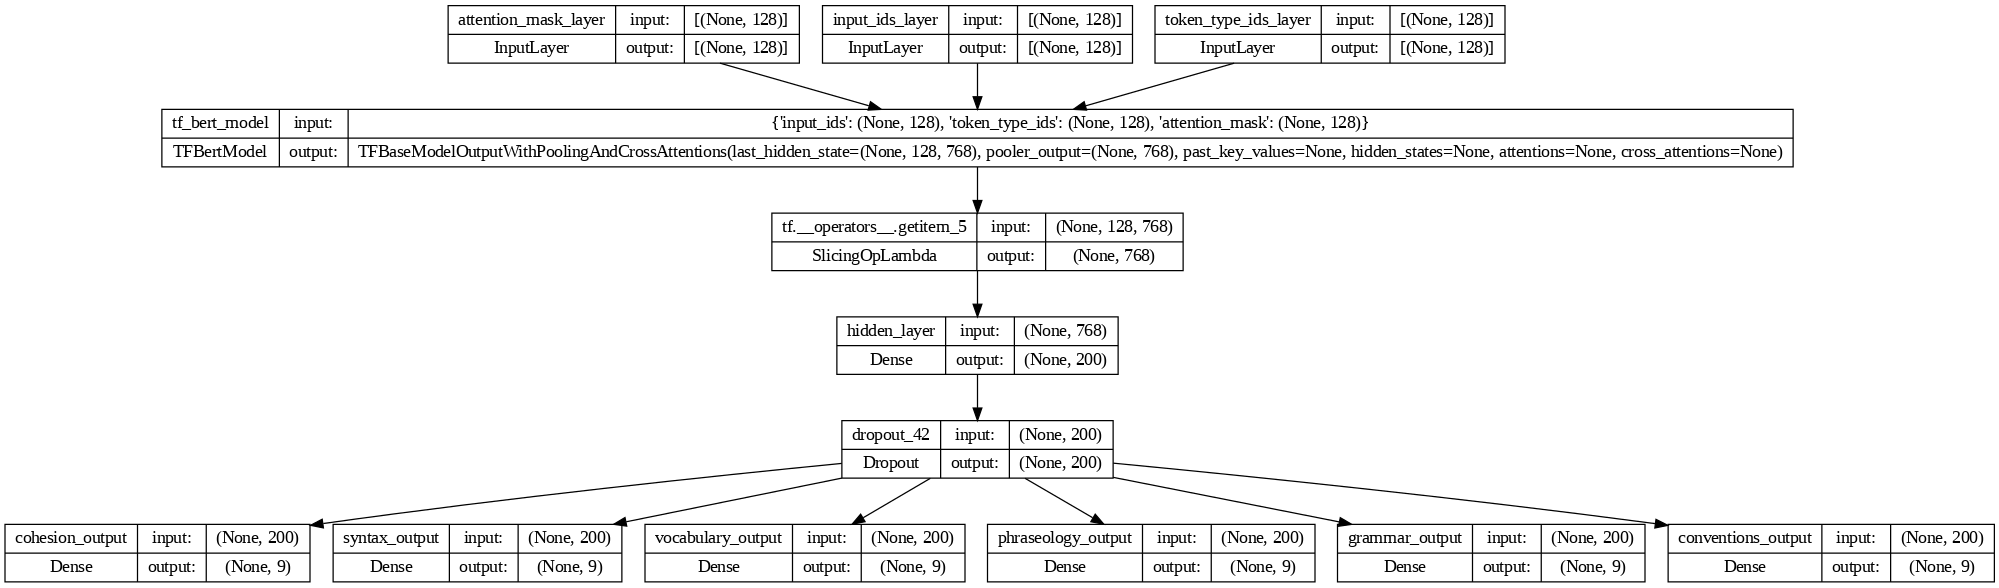

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10
)

Epoch 1/10
98/98 [==============================] - 59s 411ms/step - loss: 10.6954 - cohesion_output_loss: 1.7380 - syntax_output_loss: 2.3179 - vocabulary_output_loss: 1.5751 - phraseology_output_loss: 1.6556 - grammar_output_loss: 1.6833 - conventions_output_loss: 1.7255 - cohesion_output_accuracy: 0.1643 - syntax_output_accuracy: 0.0777 - vocabulary_output_accuracy: 0.2733 - phraseology_output_accuracy: 0.2196 - grammar_output_accuracy: 0.1781 - conventions_output_accuracy: 0.1905 - val_loss: 7.4939 - val_cohesion_output_loss: 1.2134 - val_syntax_output_loss: 1.4798 - val_vocabulary_output_loss: 1.0518 - val_phraseology_output_loss: 1.2475 - val_grammar_output_loss: 1.2286 - val_conventions_output_loss: 1.2728 - val_cohesion_output_accuracy: 0.2669 - val_syntax_output_accuracy: 0.1507 - val_vocabulary_output_accuracy: 0.3857 - val_phraseology_output_accuracy: 0.2925 - val_grammar_output_accuracy: 0.2682 - val_conventions_output_accuracy: 0.2925
Epoch 2/10
98/98 [====================

In [ ]:
pd.DataFrame(bert_classification_model_history.history)

,loss,cohesion_output_loss,syntax_output_loss,vocabulary_output_loss,phraseology_output_loss,grammar_output_loss,conventions_output_loss,cohesion_output_accuracy,syntax_output_accuracy,vocabulary_output_accuracy,phraseology_output_accuracy,grammar_output_accuracy,conventions_output_accuracy,val_loss,val_cohesion_output_loss,val_syntax_output_loss,val_vocabulary_output_loss,val_phraseology_output_loss,val_grammar_output_loss,val_conventions_output_loss,val_cohesion_output_accuracy,val_syntax_output_accuracy,val_vocabulary_output_accuracy,val_phraseology_output_accuracy,val_grammar_output_accuracy,val_conventions_output_accuracy
0,10.695362,1.738018,2.317859,1.575100,1.655570,1.683319,1.725497,0.164322,0.077685,0.273338,0.219629,0.178069,0.190537,7.493863,1.213382,1.479766,1.051773,1.247467,1.228630,1.272846,0.266922,0.150702,0.385696,0.292465,0.268199,0.292465
1,7.643335,1.296028,1.356168,1.133975,1.255056,1.294810,1.307300,0.232417,0.230818,0.355179,0.260230,0.223785,0.241368,6.446733,1.086744,1.090850,0.980365,1.113705,1.069477,1.105591,0.275862,0.314176,0.385696,0.293742,0.284802,0.295019
2,7.124394,1.230541,1.160344,1.108008,1.200484,1.208526,1.216490,0.234974,0.272059,0.350703,0.257673,0.216752,0.245844,6.184259,1.059172,1.047798,0.950181,1.062523,1.012755,1.051832,0.277139,0.319285,0.385696,0.297573,0.298851,0.297573
3,6.826335,1.194981,1.096295,1.074974,1.150004,1.151324,1.158756,0.245844,0.279412,0.358376,0.261829,0.233696,0.257992,6.039941,1.035274,1.019115,0.934924,1.032739,0.992420,1.025469,0.277139,0.329502,0.385696,0.297573,0.307791,0.306513
4,6.641357,1.166892,1.054136,1.063013,1.093189,1.148966,1.115159,0.239450,0.293478,0.351023,0.273018,0.238171,0.265985,5.911210,1.018555,0.988669,0.914963,1.010693,0.973258,1.005071,0.274585,0.335888,0.385696,0.298851,0.310345,0.311622
5,6.579259,1.137167,1.067734,1.035390,1.112077,1.115981,1.110911,0.246483,0.286125,0.354859,0.264066,0.242327,0.268223,5.847808,1.008705,0.981059,0.908971,1.001630,0.961180,0.986263,0.270754,0.339719,0.385696,0.298851,0.307791,0.318008
6,6.388950,1.111790,1.031140,1.005180,1.075148,1.092749,1.072944,0.243286,0.298274,0.359335,0.266944,0.250000,0.278133,5.786863,1.002451,0.973426,0.895584,0.987791,0.951109,0.976502,0.270754,0.344828,0.386973,0.302682,0.315453,0.321839
7,6.339627,1.101189,1.040355,0.992458,1.057529,1.080001,1.068097,0.250320,0.286125,0.364770,0.278133,0.255115,0.277174,5.711965,0.995637,0.953811,0.877985,0.974540,0.940950,0.969043,0.275862,0.342273,0.384419,0.307791,0.312899,0.316731
8,6.244352,1.096637,1.001751,0.990989,1.060949,1.055477,1.038547,0.250959,0.296995,0.361573,0.269821,0.261829,0.286765,5.704742,0.990947,0.951863,0.883821,0.968249,0.939476,0.970386,0.274585,0.349936,0.386973,0.314176,0.314176,0.318008
9,6.166960,1.071223,1.001289,0.970097,1.043484,1.045075,1.035790,0.256074,0.299233,0.363171,0.276535,0.255435,0.283887,5.676095,0.990813,0.949978,0.878920,0.968199,0.929297,0.958888,0.278416,0.352490,0.385696,0.312899,0.315453,0.318008


In [ ]:
pd.DataFrame(bert_classification_model_history.history).loc[9, 'val_cohesion_output_accuracy':]

val_cohesion_output_accuracy       0.278416
val_syntax_output_accuracy         0.352490
val_vocabulary_output_accuracy     0.385696
val_phraseology_output_accuracy    0.312899
val_grammar_output_accuracy        0.315453
val_conventions_output_accuracy    0.318008
Name: 9, dtype: float64

In [ ]:
predicted_probabilities = bert_classification_model.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

25/25 [==============================] - 10s 284ms/step


In [ ]:
predictions = tf.argmax(predicted_probabilities, axis=-1)

*Cohesion*

In [ ]:
print(classification_report(2*y_test[0], 2*predictions[0].numpy()))

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         7
         4.0       0.28      0.31      0.29        62
         5.0       0.00      0.00      0.00       151
         6.0       0.28      0.92      0.43       215
         7.0       0.00      0.00      0.00       219
         8.0       0.14      0.01      0.02       103
         9.0       0.00      0.00      0.00        19
        10.0       0.00      0.00      0.00         5

    accuracy                           0.28       783
   macro avg       0.08      0.14      0.08       783
weighted avg       0.12      0.28      0.14       783



In [ ]:
cm = tf.math.confusion_matrix(2*y_test[0], 2*predictions[0].numpy())
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

<Figure size 2000x700 with 0 Axes>

<Axes: >

Text(0.5, 47.7222222222222, 'Predicted')

Text(220.72222222222223, 0.5, 'True')

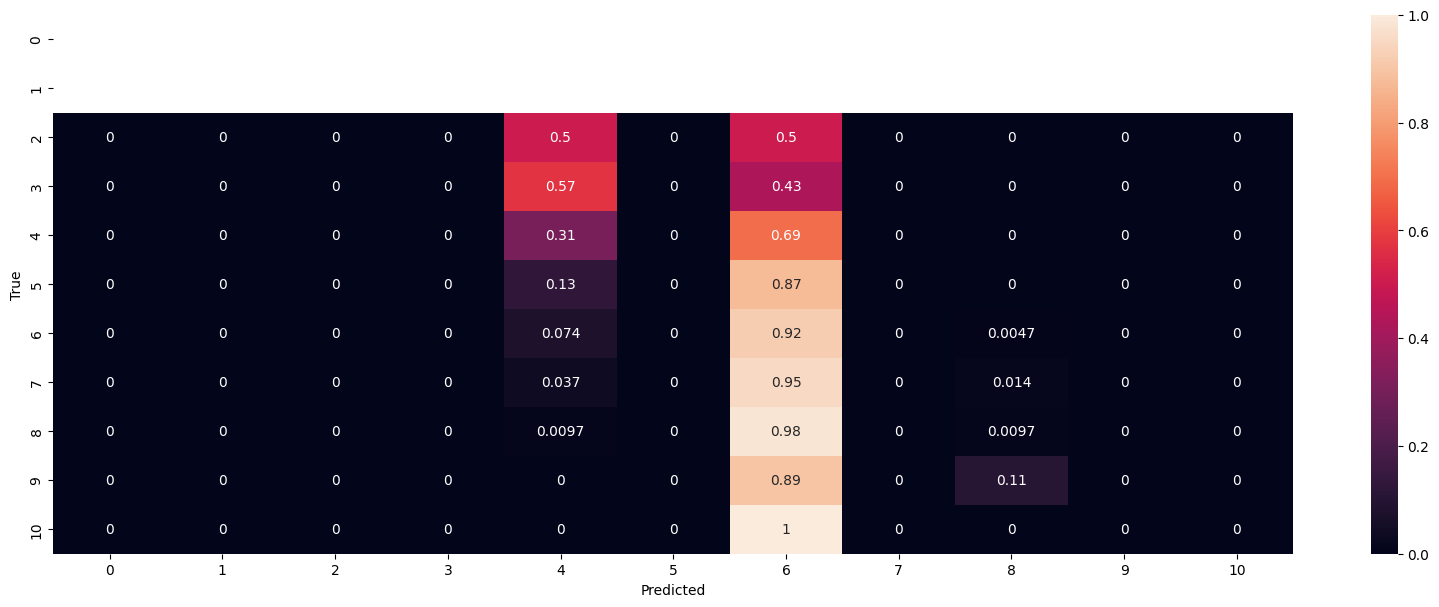

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(cm,
            annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

*Okay, so it looks like our model is only predicting a score of 2, 3, or 4 for the `cohesion` category. If you inspect the other 5 categories, you will find that it never predicts anything outside of {2, 3, 4}.*

This is problematic for a few reasons.

1. First of all, it doesn't seem to realize that scores of 1.5, 2.5, etc are possible. I think this can easily be fixed by multiplying the target by 2 prior to training. **Update:** I try to do that below and it doesn't work, I think there's just some small problem in the way that the target is interpretted by the model that's messing everything up.

2. It seems like the model is taking advantage of the fact that the target is normally distributed. That is, the lowest class - 1 - and the highest class - 5 - are far less common than the middle classes. This behavior isn't ideal: we'd prefer for the model to approach an essay without a pre-conceived notion of the relative likelihood of the different classes. Unfortunateely, solving this problem is probably much harder. I do think that using a loss function which leverages the ordinal nature of the target will help. We'll see

Try to fix problem (1)

In [ ]:
bert_classification_model_2 = create_bert_classification_model(bert_model, num_train_layers=0)

In [ ]:
y_train_transformed = [2*cat for cat in y_train]
y_test_transformed = [2*cat for cat in y_test]

bert_classification_model_history_2 = bert_classification_model_2.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train_transformed,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test_transformed),
    batch_size=32,
    epochs=10
)

Epoch 1/10
81/98 [=======================>......] - ETA: 5s - loss: nan - cohesion_output_loss: nan - syntax_output_loss: nan - vocabulary_output_loss: nan - phraseology_output_loss: nan - grammar_output_loss: nan - conventions_output_loss: nan - cohesion_output_accuracy: 7.7160e-04 - syntax_output_accuracy: 0.0000e+00 - vocabulary_output_accuracy: 3.8580e-04 - phraseology_output_accuracy: 0.0015 - grammar_output_accuracy: 0.0019 - conventions_output_accuracy: 0.0023

KeyboardInterrupt: ignored

In [ ]:
predicted_probabilities_2 = bert_classification_model_2.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

25/25 [==============================] - 11s 282ms/step


In [ ]:
predicted_probabilities_2[0][0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [ ]:
predictions_2 = tf.argmax(predicted_probabilities_2, axis=-1)

Try to fix problem (2)

In [ ]:
# I want to make a slight variation of the model where we treat the target as ordinal rather than nominal. I think there are several ways
# to do so, but one that I came across is to use the loss function tfa.losses.WeightedKappaLoss() in the model compilation. Unfortunately,
# if you try to train this model on our data it throws an error. I haven't investigated the error thoroughly yet.

def create_bert_classification_model_2(bert_model,
                                       num_train_layers=0,
                                       hidden_size = 200,
                                       dropout = 0.3,
                                       learning_rate = 0.00005,
                                       MAX_SEQUENCE_LENGTH = 128,
                                       num_classes = 9):
    """
    This second iteration of the model uses a different loss function: WeightedKappaLoss
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    cohesion_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='cohesion_output')(hidden)
    syntax_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='syntax_output')(hidden)
    vocabulary_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='vocabulary_output')(hidden)
    phraseology_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='phraseology_output')(hidden)
    grammar_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='grammar_output')(hidden)
    conventions_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='conventions_output')(hidden)

    inputs = [input_ids, token_type_ids, attention_mask]
    outputs = [cohesion_score, syntax_score, vocabulary_score, phraseology_score, grammar_score, conventions_score]

    classification_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tfa.losses.WeightedKappaLoss(num_classes=num_classes,
                                                                   weightage="quadratic"),
                                 metrics=['accuracy'])

    return classification_model

In [ ]:
# pretrain hyperparameters dataframe


---
## 4. Model 2 dataset (original dataset) <a name='ds2'></a>
[jump to top](#top)<br>

In [ ]:
# File path to the dataset
file_path = '/content/drive/MyDrive/Colab/training_set_rel3.xlsx'

# Read the dataset into a Pandas DataFrame

train = pd.read_excel(file_path)
print(train.shape)
train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,NaN,35.0,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,NaN,32.0,NaN,NaN,NaN,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12976,21630,8,Trippin' on fen...,20.0,20.0,NaN,40.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


---
### 4a. Preprocessing <a name='ds2preprocess'></a>
[jump to top](#top)<br>

---
### 4b. EDA <a name='ds2explore'></a>
[jump to top](#top)<br>

In [ ]:
train.iloc[1, ]['essay']

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

In [ ]:
train.isna().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        1
rater2_domain1        1
rater3_domain1    12850
domain1_score         1
rater1_domain2    11178
rater2_domain2    11178
domain2_score     11178
rater1_trait1     10686
rater1_trait2     10686
rater1_trait3     10686
rater1_trait4     10686
rater1_trait5     12255
rater1_trait6     12255
rater2_trait1     10686
rater2_trait2     10686
rater2_trait3     10686
rater2_trait4     10686
rater2_trait5     12255
rater2_trait6     12255
rater3_trait1     12850
rater3_trait2     12850
rater3_trait3     12850
rater3_trait4     12850
rater3_trait5     12850
rater3_trait6     12850
dtype: int64

In [ ]:
train = train[['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score', 'domain2_score']]
train

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,NaN
...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,35.0,NaN
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,32.0,NaN
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,NaN
12976,21630,8,Trippin' on fen...,20.0,20.0,40.0,NaN


In [ ]:
train1 = train[train['essay_set'] == 1]
print('Max Score for Essay 1 is', train1.domain1_score.max())



train3 = train[train['essay_set'] == 3]
print('Max Score for Essay 3 is', train3.domain1_score.max())

train7 = train[train['essay_set'] == 7] #pretty sure the essay set description does not match its rubric
print('Max Score for Essay 7 is', train7.domain1_score.max())

Max Score for Essay 1 is 12.0
Max Score for Essay 3 is 3.0
Max Score for Essay 7 is 24.0


In [ ]:
#train2 for example has two final scores
train2 = train[train['essay_set'] == 2]
train2

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score
1783,2978,2,Certain materials being removed from libraries...,4.0,4.0,4.0,4.0
1784,2979,2,Write a persuasive essay to a newspaper reflec...,1.0,2.0,1.0,1.0
1785,2980,2,Do you think that libraries should remove cert...,2.0,3.0,2.0,3.0
1786,2981,2,"In @DATE1's world, there are many things found...",4.0,4.0,4.0,4.0
1787,2982,2,In life you have the 'offensive things'. The l...,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...
3578,4773,2,The author is writting about taking books off ...,3.0,2.0,3.0,3.0
3579,4774,2,"I do not think that materials, such as books, ...",3.0,3.0,3.0,3.0
3580,4775,2,"Yes we should keep the books,music,movies,an m...",2.0,2.0,2.0,2.0
3581,4776,2,"I do believe that book, magazines, music, mov...",3.0,4.0,3.0,4.0


In [ ]:
#replace na in the domain2 score for each essay that doesn't have it to zero. add to combined score

train['domain2_score'] = train['domain2_score'].fillna(0)


In [ ]:
train['total'] = train['domain1_score'] + train['domain2_score']
train

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score,total
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,0.0,8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,0.0,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,0.0,7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,0.0,10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,0.0,8.0
...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,35.0,0.0,35.0
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,32.0,0.0,32.0
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,0.0,40.0
12976,21630,8,Trippin' on fen...,20.0,20.0,40.0,0.0,40.0


In [ ]:
train.groupby('essay_set')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
essay_set,,,,,,,,
1,1783.0,8.528323,1.538565,2.0,8.0,8.0,10.0,12.0
2,1800.0,6.749444,1.384822,2.0,6.0,7.0,8.0,10.0
3,1726.0,1.848204,0.815157,0.0,1.0,2.0,2.0,3.0
4,1771.0,1.431395,0.940133,0.0,1.0,1.0,2.0,3.0
5,1805.0,2.408864,0.970821,0.0,2.0,2.0,3.0,4.0
6,1800.0,2.720000,0.970630,0.0,2.0,3.0,3.0,4.0
7,1569.0,16.062460,4.585350,2.0,13.0,16.0,19.0,24.0
8,723.0,36.950207,5.753502,10.0,33.0,37.0,40.0,60.0


**Create pass/fail column**


In [ ]:
#passing scores
#for essay set 2 [4,3] were determined to be passing for each category, combine to 7
pass_dict = {1: 8,
             2: 7,
             3: 2,
             4: 2,
             5: 3,
             6: 3,
             7: 16,
             8: 24}
train['passing_score'] = train['essay_set'].map(pass_dict)
train

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score,total,passing_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,0.0,8.0,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,0.0,9.0,8
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,0.0,7.0,8
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,0.0,10.0,8
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,0.0,8.0,8
...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,35.0,0.0,35.0,24
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,32.0,0.0,32.0,24
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,0.0,40.0,24
12976,21630,8,Trippin' on fen...,20.0,20.0,40.0,0.0,40.0,24


In [ ]:
train['passed'] = train['total'] >= train['passing_score']
train

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score,total,passing_score,passed
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,0.0,8.0,8,True
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,0.0,9.0,8,True
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,0.0,7.0,8,False
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,0.0,10.0,8,True
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,0.0,8.0,8,True
...,...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,35.0,0.0,35.0,24,True
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,32.0,0.0,32.0,24,True
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,0.0,40.0,24,True
12976,21630,8,Trippin' on fen...,20.0,20.0,40.0,0.0,40.0,24,True


Note: Be careful as each essay_set has its own minimum and max scores. this info can be found in essay_set_descriptions file

**Add each essay prompt into the dataset**

In [ ]:
essay_prompts = []
#1
essay_prompts.append("""More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.""")
#2
essay_prompts.append("""Censorship in the Libraries
"All of us can think of a book that we hope none of our children or any other children have taken off the shelf. But if I have the right to remove that book from the shelf -- that work I abhor -- then you also have exactly the same right and so does everyone else. And then we have no books left on the shelf for any of us." --Katherine Paterson, Author
Write a persuasive essay to a newspaper reflecting your vies on censorship in libraries. Do you believe that certain materials, such as books, music, movies, magazines, etc., should be removed from the shelves if they are found offensive? Support your position with convincing arguments from your own experience, observations, and/or reading.
""")
#3
essay_prompts.append("""ROUGH ROAD AHEAD: Do Not Exceed Posted Speed Limit
by Joe Kurmaskie
FORGET THAT OLD SAYING ABOUT NEVER taking candy from strangers. No, a better piece of advice for the solo cyclist would be, “Never accept travel advice from a collection of old-timers who haven’t left the confines of their porches since Carter was in office.” It’s not that a group of old guys doesn’t know the terrain. With age comes wisdom and all that, but the world is a fluid place. Things change.
At a reservoir campground outside of Lodi, California, I enjoyed the serenity of an early-summer evening and some lively conversation with these old codgers. What I shouldn’t have done was let them have a peek at my map. Like a foolish youth, the next morning I followed their advice and launched out at first light along a “shortcut” that was to slice away hours from my ride to Yosemite National Park.
They’d sounded so sure of themselves when pointing out landmarks and spouting off towns I would come to along this breezy jaunt. Things began well enough. I rode into the morning with strong legs and a smile on my face. About forty miles into the pedal, I arrived at the first “town.” This place might have been a thriving little spot at one time—say, before the last world war—but on that morning it fit the traditional definition of a ghost town. I chuckled, checked my water supply, and moved on. The sun was beginning to beat down, but I barely noticed it. The cool pines and rushing rivers of Yosemite had my name written all over them.
Twenty miles up the road, I came to a fork of sorts. One ramshackle shed, several rusty pumps, and a corral that couldn’t hold in the lamest mule greeted me. This sight was troubling. I had been hitting my water bottles pretty regularly, and I was traveling through the high deserts of California in June.
I got down on my hands and knees, working the handle of the rusted water pump with all my strength. A tarlike substance oozed out, followed by brackish water feeling somewhere in the neighborhood of two hundred degrees. I pumped that handle for several minutes, but the water wouldn’t cool down. It didn’t matter. When I tried a drop or two, it had the flavor of battery acid.
The old guys had sworn the next town was only eighteen miles down the road. I could make that! I would conserve my water and go inward for an hour or so—a test of my inner spirit.
Not two miles into this next section of the ride, I noticed the terrain changing. Flat road was replaced by short, rolling hills. After I had crested the first few of these, a large highway sign jumped out at me. It read: ROUGH ROAD AHEAD: DO NOT EXCEED POSTED SPEED LIMIT.
The speed limit was 55 mph. I was doing a water-depleting 12 mph. Sometimes life can feel so cruel.
I toiled on. At some point, tumbleweeds crossed my path and a ridiculously large snake—it really did look like a diamondback—blocked the majority of the pavement in front of me. I eased past, trying to keep my balance in my dehydrated state.
The water bottles contained only a few tantalizing sips. Wide rings of dried sweat circled my shirt, and the growing realization that I could drop from heatstroke on a gorgeous day in June simply because I listened to some gentlemen who hadn’t been off their porch in decades, caused me to laugh.
It was a sad, hopeless laugh, mind you, but at least I still had the energy to feel sorry for myself. There was no one in sight, not a building, car, or structure of any kind. I began breaking the ride down into distances I could see on the horizon, telling myself that if I could make it that far, I’d be fi ne.
Over one long, crippling hill, a building came into view. I wiped the sweat from my eyes to make sure it wasn’t a mirage, and tried not to get too excited. With what I believed was my last burst of energy, I maneuvered down the hill.
In an ironic twist that should please all sadists reading this, the building—abandoned years earlier, by the looks of it—had been a Welch’s Grape Juice factory and bottling plant. A sandblasted picture of a young boy pouring a refreshing glass of juice into his mouth could still be seen.
I hung my head.
That smoky blues tune “Summertime” rattled around in the dry honeycombs of my deteriorating brain.
I got back on the bike, but not before I gathered up a few pebbles and stuck them in my mouth. I’d read once that sucking on stones helps take your mind off thirst by allowing what spit you have left to circulate. With any luck I’d hit a bump and lodge one in my throat.
It didn’t really matter. I was going to die and the birds would pick me clean, leaving only some expensive outdoor gear and a diary with the last entry in praise of old men, their wisdom, and their keen sense of direction. I made a mental note to change that paragraph if it looked like I was going to lose consciousness for the last time.
Somehow, I climbed away from the abandoned factory of juices and dreams, slowly gaining elevation while losing hope. Then, as easily as rounding a bend, my troubles, thirst, and fear were all behind me.
GARY AND WILBER’S FISH CAMP—IF YOU WANT BAIT FOR THE BIG ONES, WE’RE YOUR BEST BET!
“And the only bet,” I remember thinking.
As I stumbled into a rather modern bathroom and drank deeply from the sink, I had an overwhelming urge to seek out Gary and Wilber, kiss them, and buy some bait—any bait, even though I didn’t own a rod or reel.
An old guy sitting in a chair under some shade nodded in my direction. Cool water dripped from my head as I slumped against the wall beside him.
“Where you headed in such a hurry?”
“Yosemite,” I whispered.
“Know the best way to get there?”
I watched him from the corner of my eye for a long moment. He was even older than the group I’d listened to in Lodi.
“Yes, sir! I own a very good map.”
And I promised myself right then that I’d always stick to it in the future.
""")

#4
essay_prompts.append("""Winter Hibiscus by Minfong Ho
Saeng, a teenage girl, and her family have moved to the United States from Vietnam. As Saeng walks home after failing her driver’s test, she sees a familiar plant. Later, she goes to a florist shop to see if the plant can be purchased.
It was like walking into another world. A hot, moist world exploding with greenery. Huge flat leaves, delicate wisps of tendrils, ferns and fronds and vines of all shades and shapes grew in seemingly random profusion.
“Over there, in the corner, the hibiscus. Is that what you mean?” The florist pointed at a leafy potted plant by the corner.
There, in a shaft of the wan afternoon sunlight, was a single blood-red blossom, its five petals splayed back to reveal a long stamen tipped with yellow pollen. Saeng felt a shock of recognition so intense, it was almost visceral.1
“Saebba,” Saeng whispered.
A saebba hedge, tall and lush, had surrounded their garden, its lush green leaves dotted with vermilion flowers. And sometimes after a monsoon rain, a blossom or two would have blown into the well, so that when she drew the well water, she would find a red blossom floating in the bucket.
Slowly, Saeng walked down the narrow aisle toward the hibiscus. Orchids, lanna bushes, oleanders, elephant ear begonias, and bougainvillea vines surrounded her. Plants that she had not even realized she had known but had forgotten drew her back into her childhood world.
When she got to the hibiscus, she reached out and touched a petal gently. It felt smooth and cool, with a hint of velvet toward the center—just as she had known it would feel.
And beside it was yet another old friend, a small shrub with waxy leaves and dainty flowers with purplish petals and white centers. “Madagascar periwinkle,” its tag announced. How strange to see it in a pot, Saeng thought. Back home it just grew wild, jutting out from the cracks in brick walls or between tiled roofs.
And that rich, sweet scent—that was familiar, too. Saeng scanned the greenery around her and found a tall, gangly plant with exquisite little white blossoms on it.  “Dok Malik,” she said, savoring the feel of the word on her tongue, even as she silently noted the English name on its tag, “jasmine.”
One of the blossoms had fallen off, and carefully Saeng picked it up and smelled it. She closed her eyes and breathed in, deeply. The familiar fragrance filled her lungs, and Saeng could almost feel the light strands of her grandmother’s long gray hair, freshly washed, as she combed it out with the fine-toothed buffalo-horn comb. And when the sun had dried it, Saeng would help the gnarled old fingers knot the hair into a bun, then slip a dok Malik bud into it.
Saeng looked at the white bud in her hand now, small and fragile. Gently, she closed her palm around it and held it tight. That, at least, she could hold on to. But where was the fine-toothed comb? The hibiscus hedge? The well? Her gentle grandmother?
A wave of loss so deep and strong that it stung Saeng’s eyes now swept over her. A blink, a channel switch, a boat ride into the night, and it was all gone. Irretrievably, irrevocably gone.
And in the warm moist shelter of the greenhouse, Saeng broke down and wept.
It was already dusk when Saeng reached home. The wind was blowing harder, tearing off the last remnants of green in the chicory weeds that were growing out of the cracks in the sidewalk. As if oblivious to the cold, her mother was still out in the vegetable garden, digging up the last of the onions with a rusty trowel. She did not see Saeng until the girl had quietly knelt down next to her.
Her smile of welcome warmed Saeng. “Ghup ma laio le? You’re back?” she said cheerfully. “Goodness, it’s past five. What took you so long? How did it go? Did you—?” Then she noticed the potted plant that Saeng was holding, its leaves quivering in the wind.
Mrs. Panouvong uttered a small cry of surprise and delight. “Dok faeng-noi!” she said. “Where did you get it?”
“I bought it,” Saeng answered, dreading her mother’s next question.
“How much?”
For answer Saeng handed her mother some coins.
“That’s all?” Mrs. Panouvong said, appalled, “Oh, but I forgot! You and the
Lambert boy ate Bee-Maags . . . .”
“No, we didn’t, Mother,” Saeng said.
“Then what else—?”
“Nothing else. I paid over nineteen dollars for it.”
“You what?” Her mother stared at her incredulously. “But how could you? All the seeds for this vegetable garden didn’t cost that much! You know how much we—” She paused, as she noticed the tearstains on her daughter’s cheeks and her puffy eyes.
“What happened?” she asked, more gently.
“I—I failed the test,” Saeng said.
For a long moment Mrs. Panouvong said nothing. Saeng did not dare look her mother in the eye. Instead, she stared at the hibiscus plant and nervously tore off a leaf, shredding it to bits.
Her mother reached out and brushed the fragments of green off Saeng’s hands. “It’s a beautiful plant, this dok faeng-noi,” she finally said. “I’m glad you got it.”
“It’s—it’s not a real one,” Saeng mumbled.
“I mean, not like the kind we had at—at—” She found that she was still too shaky to say the words at home, lest she burst into tears again. “Not like the kind we had before,” she said.
“I know,” her mother said quietly. “I’ve seen this kind blooming along the lake. Its flowers aren’t as pretty, but it’s strong enough to make it through the cold months here, this winter hibiscus. That’s what matters.”
She tipped the pot and deftly eased the ball of soil out, balancing the rest of the plant in her other hand. “Look how root-bound it is, poor thing,” she said. “Let’s plant it, right now.”
She went over to the corner of the vegetable patch and started to dig a hole in the ground. The soil was cold and hard, and she had trouble thrusting the shovel into it. Wisps of her gray hair trailed out in the breeze, and her slight frown deepened the wrinkles around her eyes. There was a frail, wiry beauty to her that touched Saeng deeply.
“Here, let me help, Mother,” she offered, getting up and taking the shovel away from her.
Mrs. Panouvong made no resistance. “I’ll bring in the hot peppers and bitter melons, then, and start dinner. How would you like an omelet with slices of the bitter melon?”
“I’d love it,” Saeng said.
Left alone in the garden, Saeng dug out a hole and carefully lowered the “winter hibiscus” into it. She could hear the sounds of cooking from the kitchen now, the beating of eggs against a bowl, the sizzle of hot oil in the pan. The pungent smell of bitter melon wafted out, and Saeng’s mouth watered. It was a cultivated taste, she had discovered—none of her classmates or friends, not even Mrs. Lambert, liked it—this sharp, bitter melon that left a golden aftertaste on the tongue. But she had grown up eating it and, she admitted to herself, much preferred it to a Big Mac.
The “winter hibiscus” was in the ground now, and Saeng tamped down the soil around it. Overhead, a flock of Canada geese flew by, their faint honks clear and—yes—familiar to Saeng now. Almost reluctantly, she realized that many of the things that she had thought of as strange before had become, through the quiet repetition of season upon season, almost familiar to her now. Like the geese. She lifted her head and watched as their distinctive V was etched against the evening sky, slowly fading into the distance.
When they come back, Saeng vowed silently to herself, in the spring, when the snows melt and the geese return and this hibiscus is budding, then I will take that test again.
""")

#5
essay_prompts.append("""Narciso Rodriguez
from Home: The Blueprints of Our Lives
My parents, originally from Cuba, arrived in the United States in 1956. After living for a year in a furnished one-room apartment, twenty-one-year-old Rawedia Maria and twenty-seven-year-old Narciso Rodriguez, Sr., could afford to move into a modest, three-room apartment I would soon call home.
In 1961, I was born into this simple house, situated in a two-family, blond-brick building in the Ironbound section of Newark, New Jersey. Within its walls, my young parents created our traditional Cuban home, the very heart of which was the kitchen. My parents both shared cooking duties and unwittingly passed on to me their rich culinary skills and a love of cooking that is still with me today (and for which I am eternally grateful). Passionate Cuban music (which I adore to this day) filled the air, mixing with the aromas of the kitchen. Here, the innocence of childhood, the congregation of family and friends, and endless celebrations that encompassed both, formed the backdrop to life in our warm home.
Growing up in this environment instilled in me a great sense that “family” had nothing to do with being a blood relative. Quite the contrary, our neighborhood was made up of mostly Spanish, Cuban, and Italian immigrants at a time when overt racism was the norm and segregation prevailed in the United States. In our neighborhood, despite customs elsewhere, all of these cultures came together in great solidarity and friendship. It was a close-knit community of honest, hardworking immigrants who extended a hand to people who, while not necessarily their own kind, were clearly in need.
Our landlord and his daughter, Alegria (my babysitter and first friend), lived above us, and Alegria graced our kitchen table for meals more often than not. Also at the table were Sergio and Edelmira, my surrogate grandparents who lived in the basement apartment. (I would not know my “real” grandparents, Narciso the Elder and Consuelo, until 1970 when they were allowed to leave Cuba.) My aunts Bertha and Juanita and my cousins Arnold, Maria, and Rosemary also all lived nearby and regularly joined us at our table. Countless extended family members came and went — and there was often someone staying with us temporarily until they were able to get back on their feet. My parents always kept their arms and their door open to the many people we considered family, knowing that they would do the same for us.
My mother and father had come to this country with such courage, without any knowledge of the language or the culture. They came selflessly, as many immigrants do, to give their children a better life, even though it meant leaving behind their families, friends, and careers in the country they loved. They struggled both personally and financially, braving the harsh northern winters while yearning for their native tropics and facing cultural hardships. The barriers to work were strong and high, and my parents both had to accept that they might not be able to find the kind of jobs they deserved. In Cuba, Narciso, Sr., had worked in a laboratory and Rawedia Maria had studied chemical engineering. In the United States, they had to start their lives over entirely, taking whatever work they could find. The faith that this struggle would lead them and their children to better times drove them to endure these hard times.
I will always be grateful to my parents for their love and sacrifice. I’ve often told them that what they did was a much more courageous thing than I could have ever done. I’ve often told them of my admiration for their strength and perseverance, and I’ve thanked them repeatedly. But, in reality, there is no way to express my gratitude for the spirit of generosity impressed upon me at such an early age and the demonstration of how important family and friends are. These are two lessons that my parents did not just tell me. They showed me with their lives, and these teachings have been the basis of my life.
It was in this simple house that my parents welcomed other refugees to celebrate their arrival to this country and where I celebrated my first birthdays. It was in the warmth of the kitchen in this humble house where a Cuban feast (albeit a frugal Cuban feast) always filled the air with not just scent and music but life and love. It was here where I learned the real definition of “family.” And for this, I will never forget that house or its gracious neighborhood or the many things I learned there about how to love. I will never forget how my parents turned this simple house into a home.
— Narciso Rodriguez, Fashion designer
Hometown: Newark, New Jersey
""")

#6
essay_prompts.append("""The Mooring Mast
by Marcia Amidon Lüsted
When the Empire State Building was conceived, it was planned as the world’s tallest building, taller even than the new Chrysler Building that was being constructed at Forty-second Street and Lexington Avenue in New York. At seventy-seven stories, it was the tallest building before the Empire State began construction, and Al Smith was determined to outstrip it in height.
The architect building the Chrysler Building, however, had a trick up his sleeve. He secretly constructed a 185-foot spire inside the building, and then shocked the public and the media by hoisting it up to the top of the Chrysler Building, bringing it to a height of 1,046 feet, 46 feet taller than the originally announced height of the Empire State Building.
Al Smith realized that he was close to losing the title of world’s tallest building, and on December 11, 1929, he announced that the Empire State would now reach the height of 1,250 feet. He would add a top or a hat to the building that would be even more distinctive than any other building in the city. John Tauranac describes the plan:
[The top of the Empire State Building] would be more than ornamental, more than a spire or dome or a pyramid put there to add a desired few feet to the height of the building or to mask something as mundane as a water tank. Their top, they said, would serve a higher calling. The Empire State Building would be equipped for an age of transportation that was then only the dream of aviation pioneers.
This dream of the aviation pioneers was travel by dirigible, or zeppelin, and the Empire State Building was going to have a mooring mast at its top for docking these new airships, which would accommodate passengers on already existing transatlantic routes and new routes that were yet to come.
The Age of Dirigibles
By the 1920s, dirigibles were being hailed as the transportation of the future. Also known today as blimps, dirigibles were actually enormous steel-framed balloons, with envelopes of cotton fabric filled with hydrogen and helium to make them lighter than air. Unlike a balloon, a dirigible could be maneuvered by the use of propellers and rudders, and passengers could ride in the gondola, or enclosed compartment, under the balloon.
Dirigibles had a top speed of eighty miles per hour, and they could cruise at seventy miles per hour for thousands of miles without needing refueling. Some were as long as one thousand feet, the same length as four blocks in New York City. The one obstacle to their expanded use in New York City was the lack of a suitable landing area. Al Smith saw an opportunity for his Empire State Building: A mooring mast added to the top of the building would allow dirigibles to anchor there for several hours for refueling or service, and to let passengers off and on. Dirigibles were docked by means of an electric winch, which hauled in a line from the front of the ship and then tied it to a mast. The body of the dirigible could swing in the breeze, and yet passengers could safely get on and off the dirigible by walking down a gangplank to an open observation platform.
The architects and engineers of the Empire State Building consulted with experts, taking tours of the equipment and mooring operations at the U.S. Naval Air Station in Lakehurst, New Jersey. The navy was the leader in the research and development of dirigibles in the United States. The navy even offered its dirigible, the Los Angeles, to be used in testing the mast. The architects also met with the president of a recently formed airship transport company that planned to offer dirigible service across the Pacific Ocean.
When asked about the mooring mast, Al Smith commented:
[It’s] on the level, all right. No kidding. We’re working on the thing now. One set of engineers here in New York is trying to dope out a practical, workable arrangement and the Government people in Washington are figuring on some safe way of mooring airships to this mast.
Designing the Mast
The architects could not simply drop a mooring mast on top of the Empire State Building’s flat roof. A thousand-foot dirigible moored at the top of the building, held by a single cable tether, would add stress to the building’s frame. The stress of the dirigible’s load and the wind pressure would have to be transmitted all the way to the building’s foundation, which was nearly eleven hundred feet below. The steel frame of the Empire State Building would have to be modified and strengthened to accommodate this new situation. Over sixty thousand dollars’ worth of modifications had to be made to the building’s framework.
Rather than building a utilitarian mast without any ornamentation, the architects designed a shiny glass and chrome-nickel stainless steel tower that would be illuminated from inside, with a stepped-back design that imitated the overall shape of the building itself. The rocket-shaped mast would have four wings at its corners, of shiny aluminum, and would rise to a conical roof that would house the mooring arm. The winches and control machinery for the dirigible mooring would be housed in the base of the shaft itself, which also housed elevators and stairs to bring passengers down to the eighty-sixth floor, where baggage and ticket areas would be located.
The building would now be 102 floors, with a glassed-in observation area on the 101st floor and an open observation platform on the 102nd floor. This observation area was to double as the boarding area for dirigible passengers.
Once the architects had designed the mooring mast and made changes to the existing plans for the building’s skeleton, construction proceeded as planned. When the building had been framed to the 85th floor, the roof had to be completed before the framing for the mooring mast could take place. The mast also had a skeleton of steel and was clad in stainless steel with glass windows. Two months after the workers celebrated framing the entire building, they were back to raise an American flag again—this time at the top of the frame for the mooring mast.
The Fate of the Mast
The mooring mast of the Empire State Building was destined to never fulfill its purpose, for reasons that should have been apparent before it was ever constructed. The greatest reason was one of safety: Most dirigibles from outside of the United States used hydrogen rather than helium, and hydrogen is highly flammable. When the German dirigible Hindenburg was destroyed by fire in Lakehurst, New Jersey, on May 6, 1937, the owners of the Empire State Building realized how much worse that accident could have been if it had taken place above a densely populated area such as downtown New York.
The greatest obstacle to the successful use of the mooring mast was nature itself. The winds on top of the building were constantly shifting due to violent air currents. Even if the dirigible were tethered to the mooring mast, the back of the ship would swivel around and around the mooring mast. Dirigibles moored in open landing fields could be weighted down in the back with lead weights, but using these at the Empire State Building, where they would be dangling high above pedestrians on the street, was neither practical nor safe.
The other practical reason why dirigibles could not moor at the Empire State Building was an existing law against airships flying too low over urban areas. This law would make it illegal for a ship to ever tie up to the building or even approach the area, although two dirigibles did attempt to reach the building before the entire idea was dropped. In December 1930, the U.S. Navy dirigible Los Angeles approached the mooring mast but could not get close enough to tie up because of forceful winds. Fearing that the wind would blow the dirigible onto the sharp spires of other buildings in the area, which would puncture the dirigible’s shell, the captain could not even take his hands off the control levers.
Two weeks later, another dirigible, the Goodyear blimp Columbia, attempted a publicity stunt where it would tie up and deliver a bundle of newspapers to the Empire State Building. Because the complete dirigible mooring equipment had never been installed, a worker atop the mooring mast would have to catch the bundle of papers on a rope dangling from the blimp. The papers were delivered in this fashion, but after this stunt the idea of using the mooring mast was shelved. In February 1931, Irving Clavan of the building’s architectural office said, “The as yet unsolved problems of mooring air ships to a fixed mast at such a height made it desirable to postpone to a later date the final installation of the landing gear.”
By the late 1930s, the idea of using the mooring mast for dirigibles and their passengers had quietly disappeared. Dirigibles, instead of becoming the transportation of the future, had given way to airplanes. The rooms in the Empire State Building that had been set aside for the ticketing and baggage of dirigible passengers were made over into the world’s highest soda fountain and tea garden for use by the sightseers who flocked to the observation decks. The highest open observation deck, intended for disembarking passengers, has never been open to the public.
""")

#7

essay_prompts.append("""Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining.
Do only one of the following: write a story about a time when you were patient OR write a story about a time when someone you know was patient OR write a story in your own way about patience.
""")

#8

essay_prompts.append("""We all understand the benefits of laughter. For example, someone once said, “Laughter is the shortest distance between two people.” Many other people believe that laughter is an important part of any relationship. Tell a true story in which laughter was one element or part.""")

essay_prompts

['More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.',
 'Censorship in the Libraries\n"All of us can think of a book that we hope none of our children or any other children have taken off the shelf. But if I have the right to remove that book from the shelf -- that work I abhor -- then you also have exactly the same right and so does everyone else. And then

In [ ]:
# # uncomment to add a prompt column

# train["prompt"] = [essay_prompts[ess_set-1] for ess_set in train["essay_set"]]

**Apply the text_preprocessing() function to the essays**

In [ ]:
train["text_clean"] = train["essay"].apply(str).apply(lambda x: text_preprocessing(x))
train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score,total,passing_score,passed,text_clean
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,0.0,8.0,8,True,dear local newspaper i think effects computers...
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,0.0,9.0,8,True,dear i believe that using computers will benef...
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,0.0,7.0,8,False,dear more and more people use computers but no...
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,0.0,10.0,8,True,dear local newspaper i have found that many ex...
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,0.0,8.0,8,True,dear i know having computers has a positive ef...


### Analyze the target

**Before getting into analysis of the text, let's get an idea of what our target looks like**

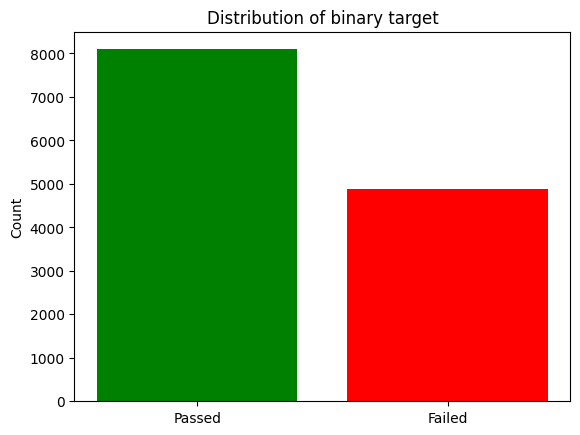

In [ ]:
plt.bar(x = ["Passed", "Failed"],
        height = [len(train[train["passed"]]), len(train[train["passed"]==False])],
        color = ["green", "red"])
plt.ylabel("Count")
plt.title("Distribution of binary target");

Let's disaggregate that by essay set

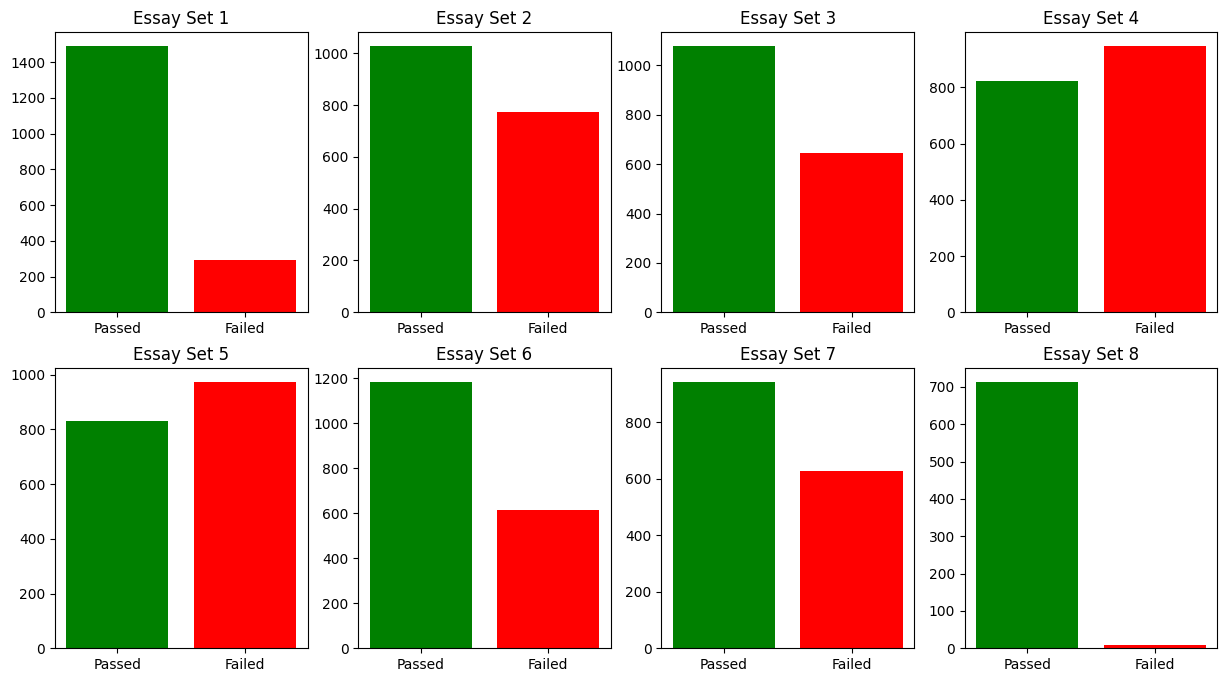

In [ ]:
sets = [train.loc[train["essay_set"]==i, :] for i in range(1, 9)]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 8))
heights = [[len(set_[set_["passed"]]), len(set_[set_["passed"]==False])] for set_ in sets]

axs[0, 0].bar(x = ["Passed", "Failed"], height = heights[0], color = ["green", "red"])
axs[0, 0].set_title("Essay Set 1")
axs[0, 1].bar(x = ["Passed", "Failed"], height = heights[1], color = ["green", "red"])
axs[0, 1].set_title("Essay Set 2")
axs[0, 2].bar(x = ["Passed", "Failed"], height = heights[2], color = ["green", "red"])
axs[0, 2].set_title("Essay Set 3")
axs[0, 3].bar(x = ["Passed", "Failed"], height = heights[3], color = ["green", "red"])
axs[0, 3].set_title("Essay Set 4")
axs[1, 0].bar(x = ["Passed", "Failed"], height = heights[4], color = ["green", "red"])
axs[1, 0].set_title("Essay Set 5")
axs[1, 1].bar(x = ["Passed", "Failed"], height = heights[5], color = ["green", "red"])
axs[1, 1].set_title("Essay Set 6")
axs[1, 2].bar(x = ["Passed", "Failed"], height = heights[6], color = ["green", "red"])
axs[1, 2].set_title("Essay Set 7")
axs[1, 3].bar(x = ["Passed", "Failed"], height = heights[7], color = ["green", "red"])
axs[1, 3].set_title("Essay Set 8");

Let's also look at the distribution of the `total` column for each of the essay sets. We'll add a vertical black line for each of them to indicate the minimum passing score.

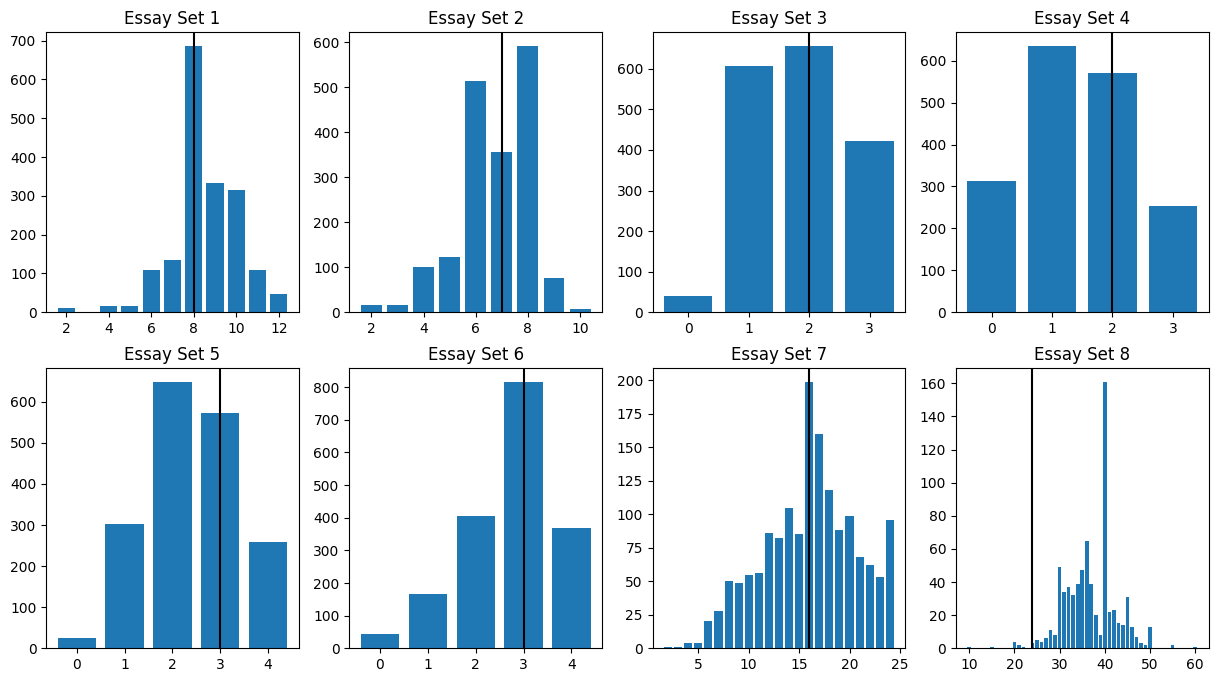

In [ ]:
val_counts = [set_["total"].value_counts() for set_ in sets]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 8))

axs[0, 0].bar(x = val_counts[0].index, height = val_counts[0].values)
axs[0, 0].set_title("Essay Set 1")
axs[0, 0].axvline(8, color = "black")
axs[0, 1].bar(x = val_counts[1].index, height = val_counts[1].values)
axs[0, 1].set_title("Essay Set 2")
axs[0, 1].axvline(7, color = "black")
axs[0, 2].bar(x = val_counts[2].index, height = val_counts[2].values)
axs[0, 2].set_title("Essay Set 3")
axs[0, 2].axvline(2, color = "black")
axs[0, 3].bar(x = val_counts[3].index, height = val_counts[3].values)
axs[0, 3].set_title("Essay Set 4")
axs[0, 3].axvline(2, color = "black")
axs[1, 0].bar(x = val_counts[4].index, height = val_counts[4].values)
axs[1, 0].set_title("Essay Set 5")
axs[1, 0].axvline(3, color = "black")
axs[1, 1].bar(x = val_counts[5].index, height = val_counts[5].values)
axs[1, 1].set_title("Essay Set 6")
axs[1, 1].axvline(3, color = "black")
axs[1, 2].bar(x = val_counts[6].index, height = val_counts[6].values)
axs[1, 2].set_title("Essay Set 7")
axs[1, 2].axvline(16, color = "black")
axs[1, 3].bar(x = val_counts[7].index, height = val_counts[7].values)
axs[1, 3].set_title("Essay Set 8")
axs[1, 3].axvline(24, color = "black");

Count the number of words in each essay

In [ ]:
train['word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))
train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,domain2_score,total,passing_score,passed,text_clean,word_count
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,0.0,8.0,8,True,dear local newspaper i think effects computers...,332
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,0.0,9.0,8,True,dear i believe that using computers will benef...,409
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,0.0,7.0,8,False,dear more and more people use computers but no...,272
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,0.0,10.0,8,True,dear local newspaper i have found that many ex...,483
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,0.0,8.0,8,True,dear i know having computers has a positive ef...,461


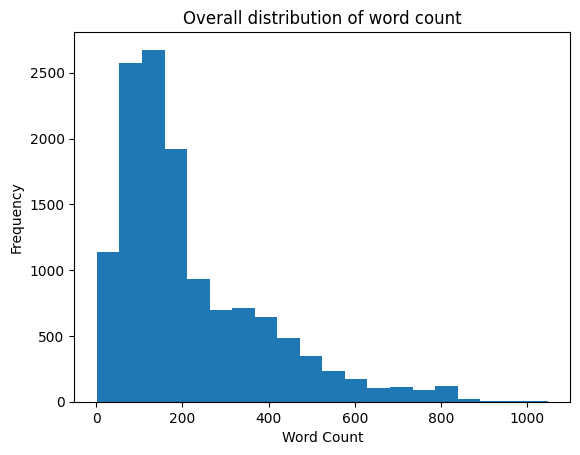

In [ ]:
plt.hist(train["word_count"], bins = 20)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Overall distribution of word count");

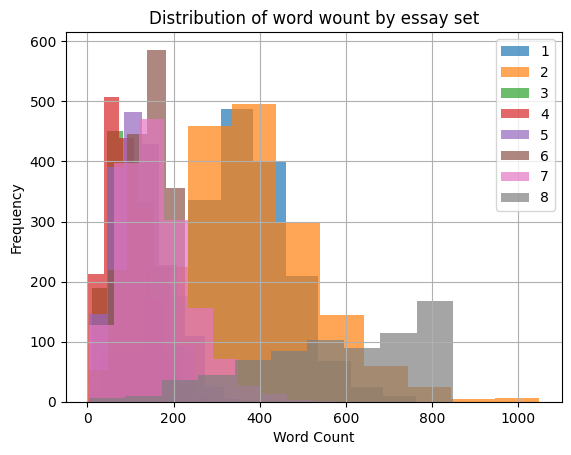

In [ ]:
train.groupby("essay_set")["word_count"].hist(alpha = 0.7, legend=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of word wount by essay set");

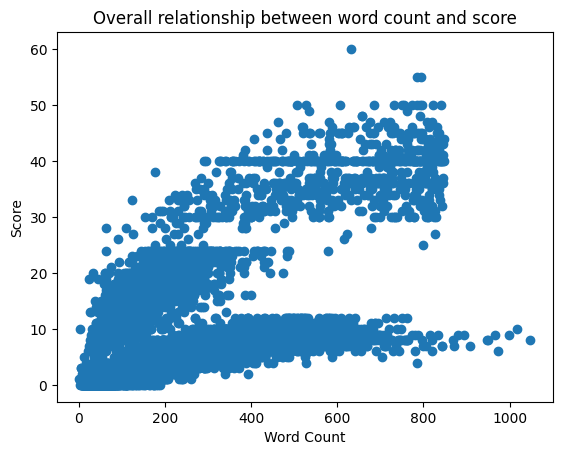

In [ ]:
plt.scatter(train["word_count"], train["total"])
plt.xlabel("Word Count")
plt.ylabel("Score")
plt.title("Overall relationship between word count and score");

**Let's disaggregate that scatterplot by essay set group because of the differing ranges of total**

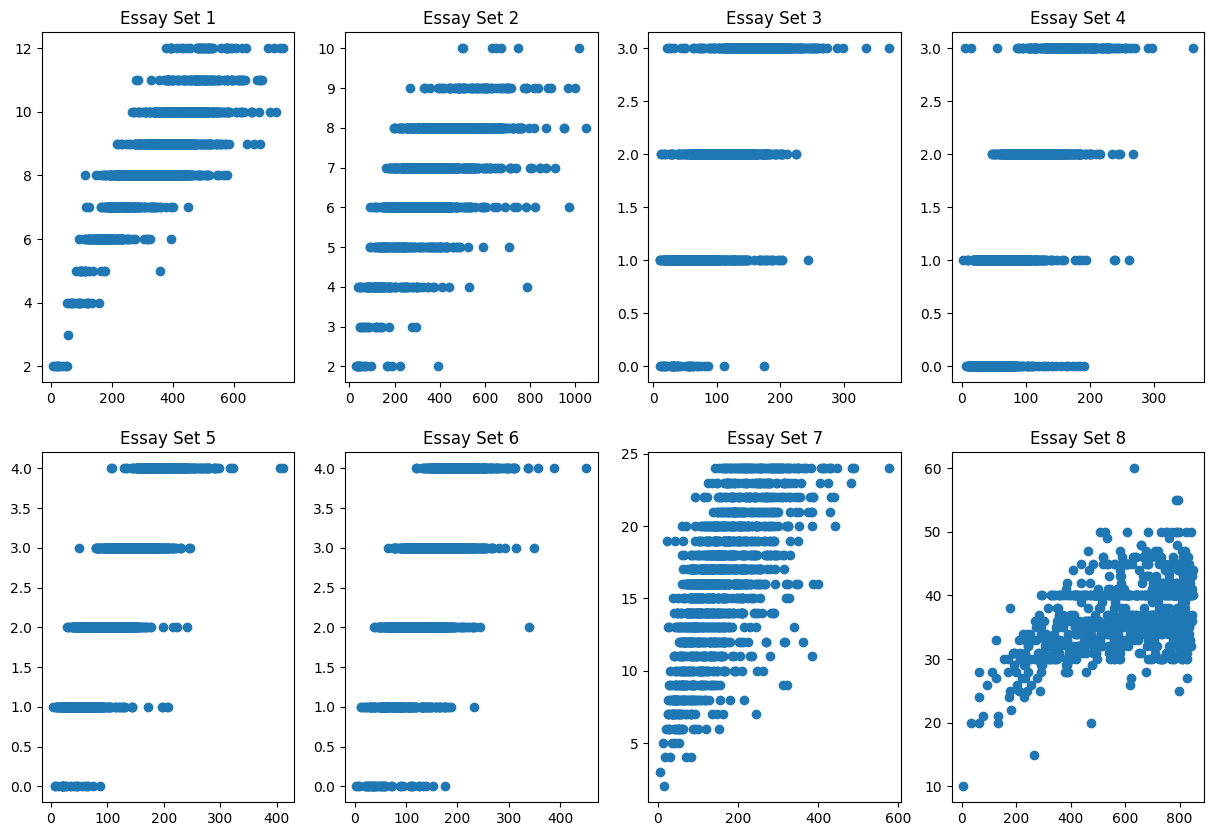

In [ ]:
sets = [train.loc[train["essay_set"]==i, ["essay_set", "word_count", "total"]] for i in range(1, 9)]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 10))

axs[0, 0].scatter(sets[0]["word_count"], sets[0]["total"])
axs[0, 0].set_title("Essay Set 1")
axs[0, 1].scatter(sets[1]["word_count"], sets[1]["total"])
axs[0, 1].set_title("Essay Set 2")
axs[0, 2].scatter(sets[2]["word_count"], sets[2]["total"])
axs[0, 2].set_title("Essay Set 3")
axs[0, 3].scatter(sets[3]["word_count"], sets[3]["total"])
axs[0, 3].set_title("Essay Set 4")
axs[1, 0].scatter(sets[4]["word_count"], sets[4]["total"])
axs[1, 0].set_title("Essay Set 5")
axs[1, 1].scatter(sets[5]["word_count"], sets[5]["total"])
axs[1, 1].set_title("Essay Set 6")
axs[1, 2].scatter(sets[6]["word_count"], sets[6]["total"])
axs[1, 2].set_title("Essay Set 7")
axs[1, 3].scatter(sets[7]["word_count"], sets[7]["total"])
axs[1, 3].set_title("Essay Set 8");

Figure above has total (score) on the y-axis and word_count on the x-axis (Labeling axes was taking too long)

**Now let's look at word uniqueness.** We'll create a new column called `word_diversity_score` which divides the number of unique words in an essay by the total number of words in that essay

In [ ]:
train["word_diversity_score"] = train["text_clean"].apply(lambda x: len(set(str(x).split())))/train["word_count"]

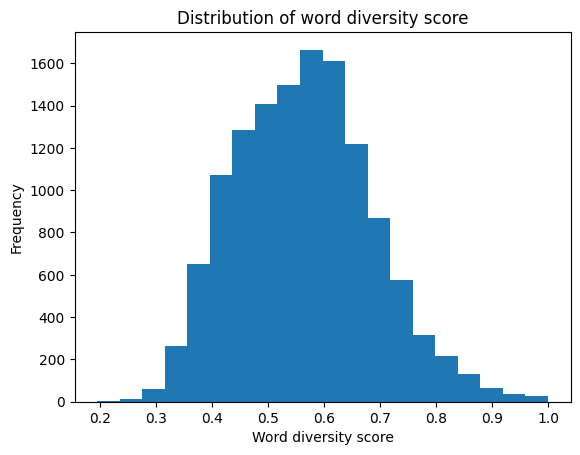

In [ ]:
# first let's look at the distribution

plt.hist(train["word_diversity_score"], bins = 20)
plt.xlabel("Word diversity score")
plt.ylabel("Frequency")
plt.title("Distribution of word diversity score");

KeyError: ignored

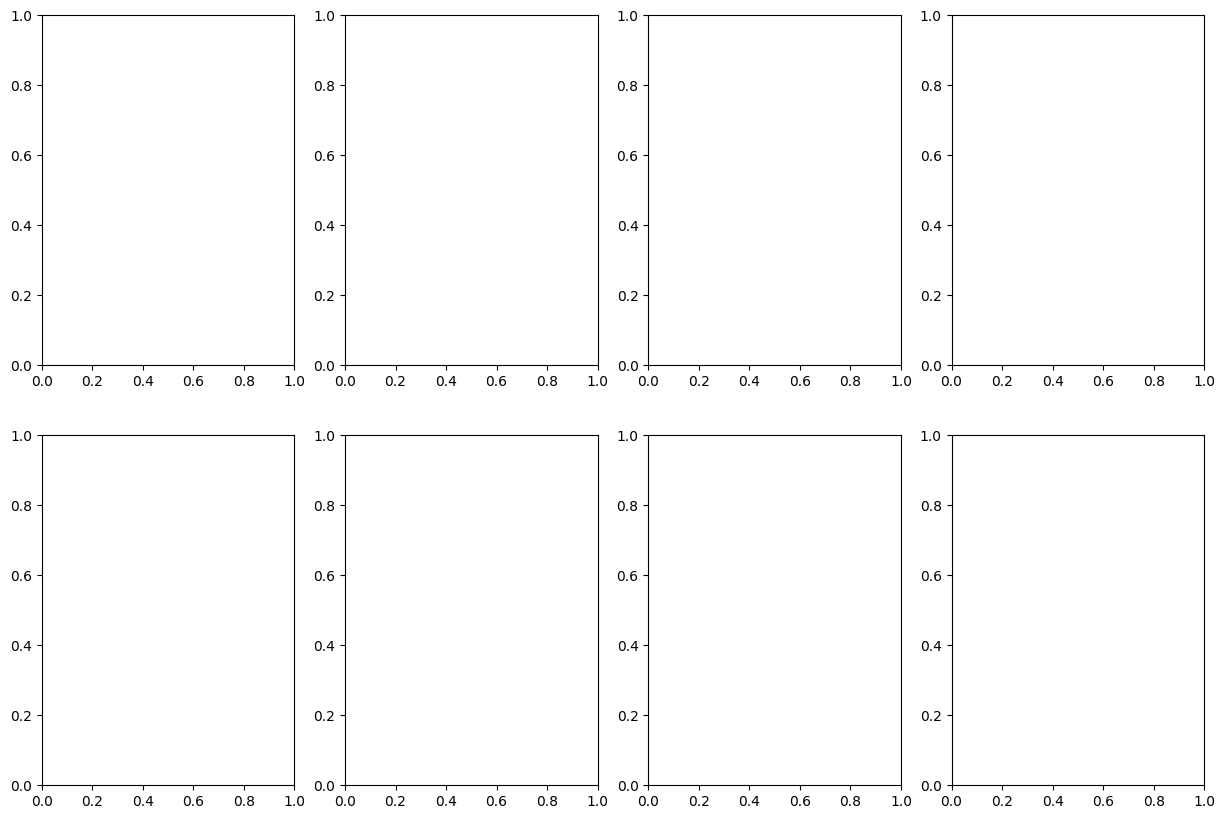

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 10))

axs[0, 0].scatter(sets[0]["word_diversity_score"], sets[0]["total"])
axs[0, 0].set_title("Essay Set 1")
axs[0, 1].scatter(sets[1]["word_diversity_score"], sets[1]["total"])
axs[0, 1].set_title("Essay Set 2")
axs[0, 2].scatter(sets[2]["word_diversity_score"], sets[2]["total"])
axs[0, 2].set_title("Essay Set 3")
axs[0, 3].scatter(sets[3]["word_diversity_score"], sets[3]["total"])
axs[0, 3].set_title("Essay Set 4")
axs[1, 0].scatter(sets[4]["word_diversity_score"], sets[4]["total"])
axs[1, 0].set_title("Essay Set 5")
axs[1, 1].scatter(sets[5]["word_diversity_score"], sets[5]["total"])
axs[1, 1].set_title("Essay Set 6")
axs[1, 2].scatter(sets[6]["word_diversity_score"], sets[6]["total"])
axs[1, 2].set_title("Essay Set 7")
axs[1, 3].scatter(sets[7]["word_diversity_score"], sets[7]["total"])
axs[1, 3].set_title("Essay Set 8");

Okay it looks like my hypothesis that essays with high word diversity would score higher was wrong! In several essay sets it looks like the opposite is actually true. This could be because shorter essays are more likely to have a high word diversity and also more likely to score poorly. We could probably create an even more complex variable that would take into account length and word diversity, but I don't think that would be productive.

---
### 4c. Modeling <a name='ds2modeling'></a>
[jump to top](#top)<br>